# Including X-ray Responses and XSPEC Models with Sherpa

In this notebook, we'll explore whether we can use Sherpa to access XSPEC models and work with the response files used for X-ray spectroscopy with CCD instruments like Chandra.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

import numpy as np

import astropy.io.fits as fits

In [2]:
import sherpa.astro.ui as ui
import astropy.modeling.models as models
from astropy.modeling.fitting import _fitter_to_model_params

Dynamic grouping functions will not be available.


In [15]:
datadir = "./"

In [16]:
ui.load_data(id="p1", filename=datadir+"fake_acis.pha")

statistical errors were found in file './fake_acis.pha' 
but not used; to use them, re-read with use_errors=True
read ARF file arfs/aciss_hetg0_cy19.arf
read RMF file rmfs/aciss_hetg0_cy19.rmf


In [17]:
d = ui.get_data("p1")

In [18]:
# conversion factor from keV to angstrom
c = 12.3984191

# This is the data in angstrom
bin_lo = d.bin_lo
bin_hi = d.bin_hi
bin_mid = bin_lo + (bin_hi - bin_lo) / 2.0

counts = d.counts



<IPython.core.display.Javascript object>


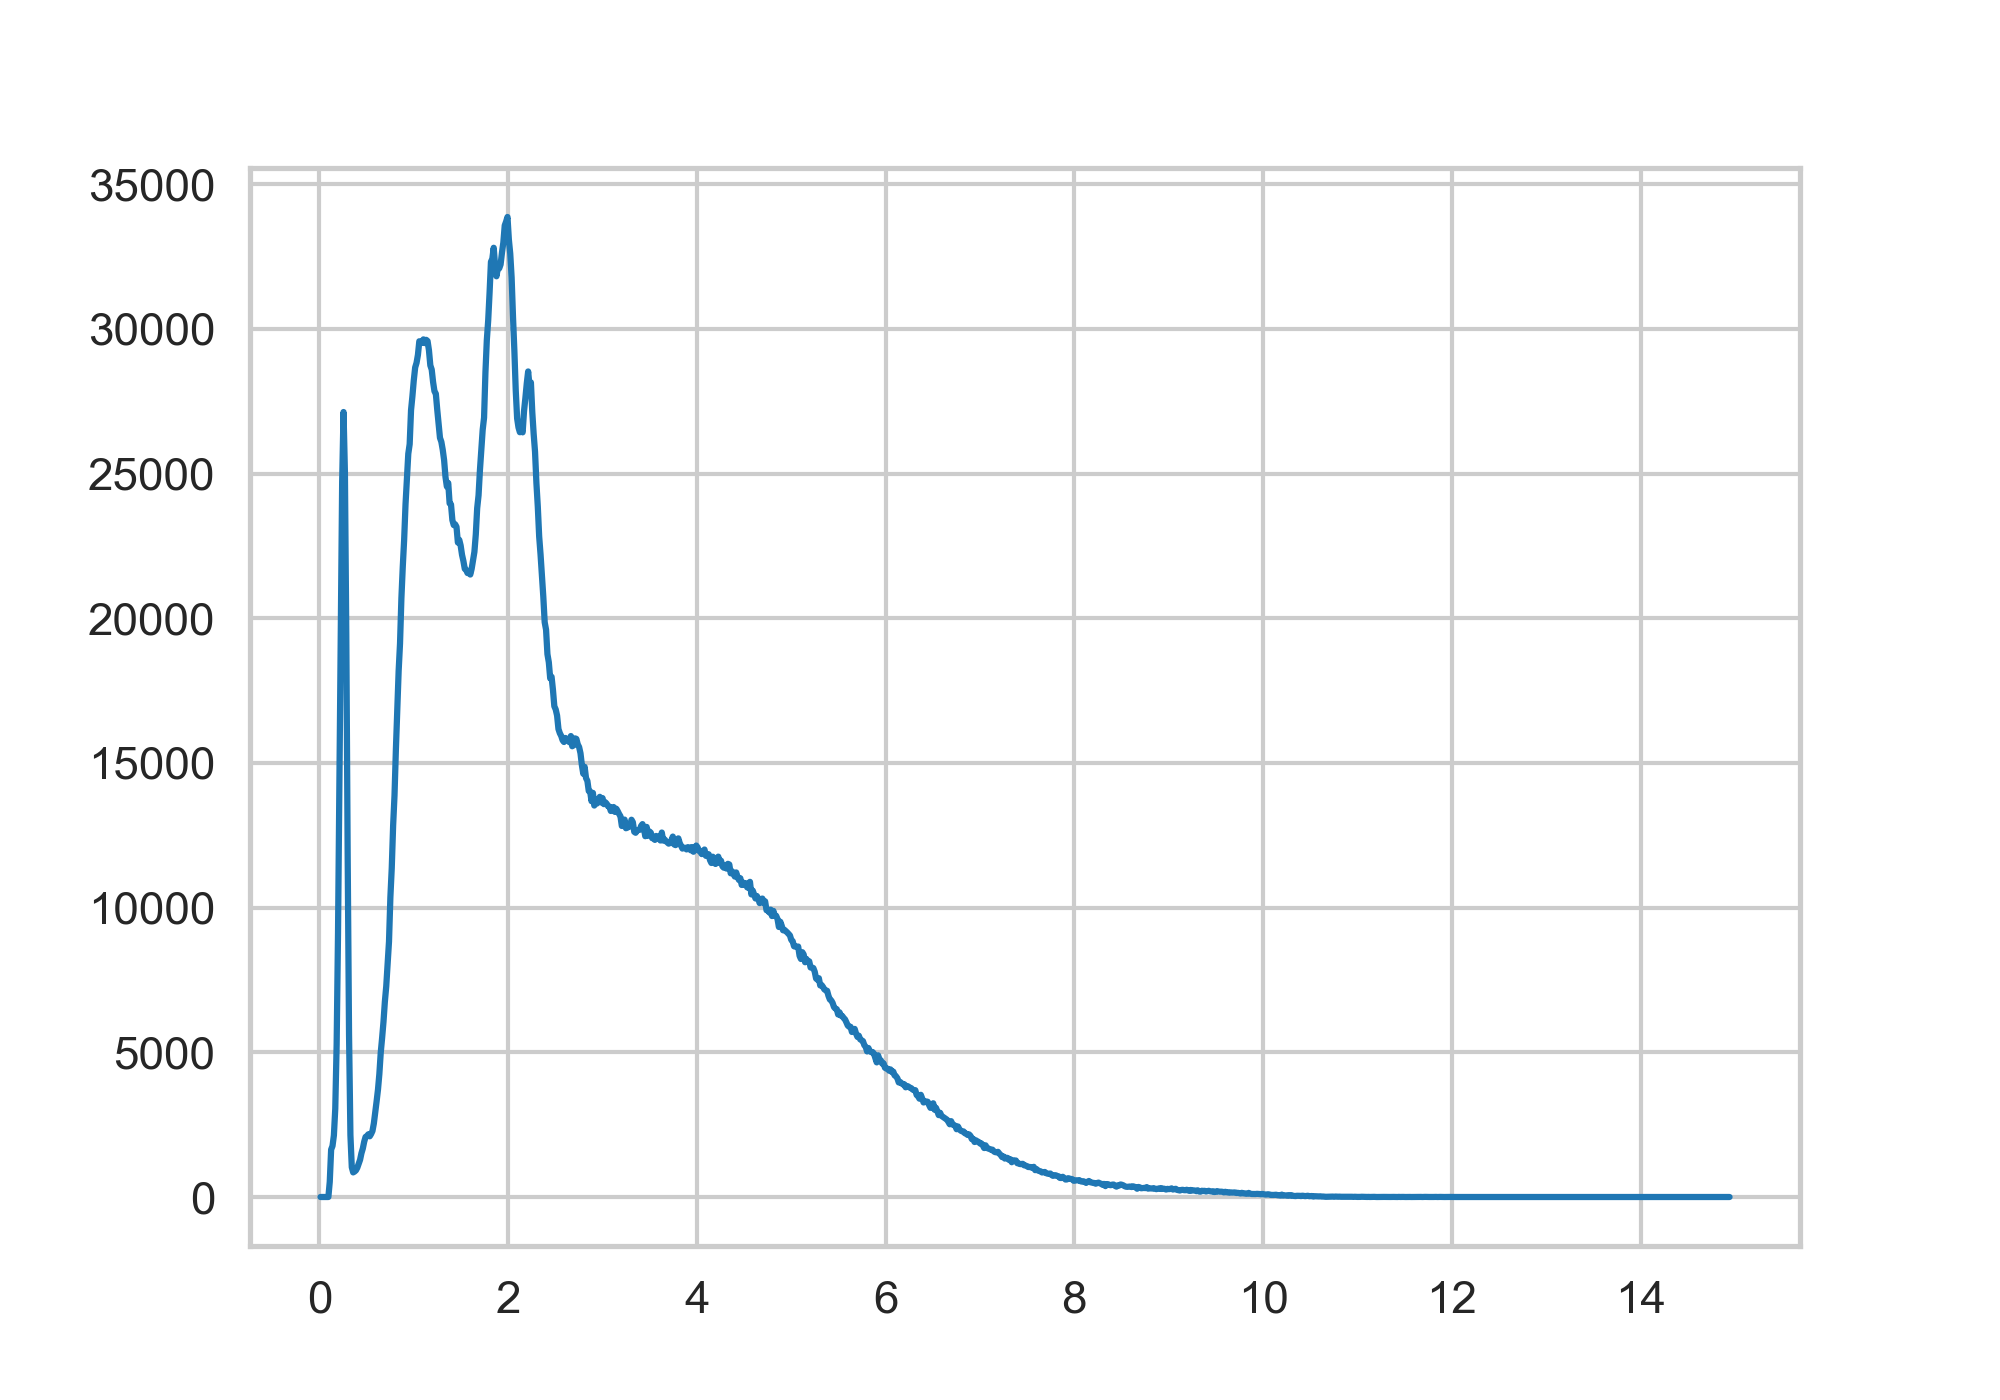

In [19]:
plt.figure(figsize=(10,7))
plt.plot(bin_mid, counts)

Let's load in the anxillary response file and the response matrix:

In [27]:
arf = d.get_arf() # get out an ARF object
rmf = d.get_rmf() # get out an RMF object

In [39]:
exposure = arf.exposure # exposure time in seconds
specresp = arf.specresp # the actual response in the ARF, i.e. effective area + stuff

In [40]:
energ_lo = arf.energ_lo
energ_hi = arf.energ_hi

In [41]:
len(energ_lo)

1024

In [42]:
len(bin_lo)

1024

In [43]:
np.all(energ_lo == bin_lo)

False

In [44]:
energ_lo[:10]

array([0.255     , 0.26646972, 0.27793944, 0.28940919, 0.30087891,
       0.31234863, 0.32381836, 0.33528808, 0.3467578 , 0.35822755])

In [45]:
bin_lo[:10]

array([0.0073, 0.0146, 0.0292, 0.0438, 0.0584, 0.073 , 0.0876, 0.1022,
       0.1168, 0.1314])

In [46]:
np.min(energ_lo)

0.2549999952316284

In [47]:
np.min(bin_lo)

0.007300000172108412

In [48]:
np.max(energ_lo)

11.988530158996582

In [49]:
np.max(bin_lo)

14.935799598693848

<IPython.core.display.Javascript object>


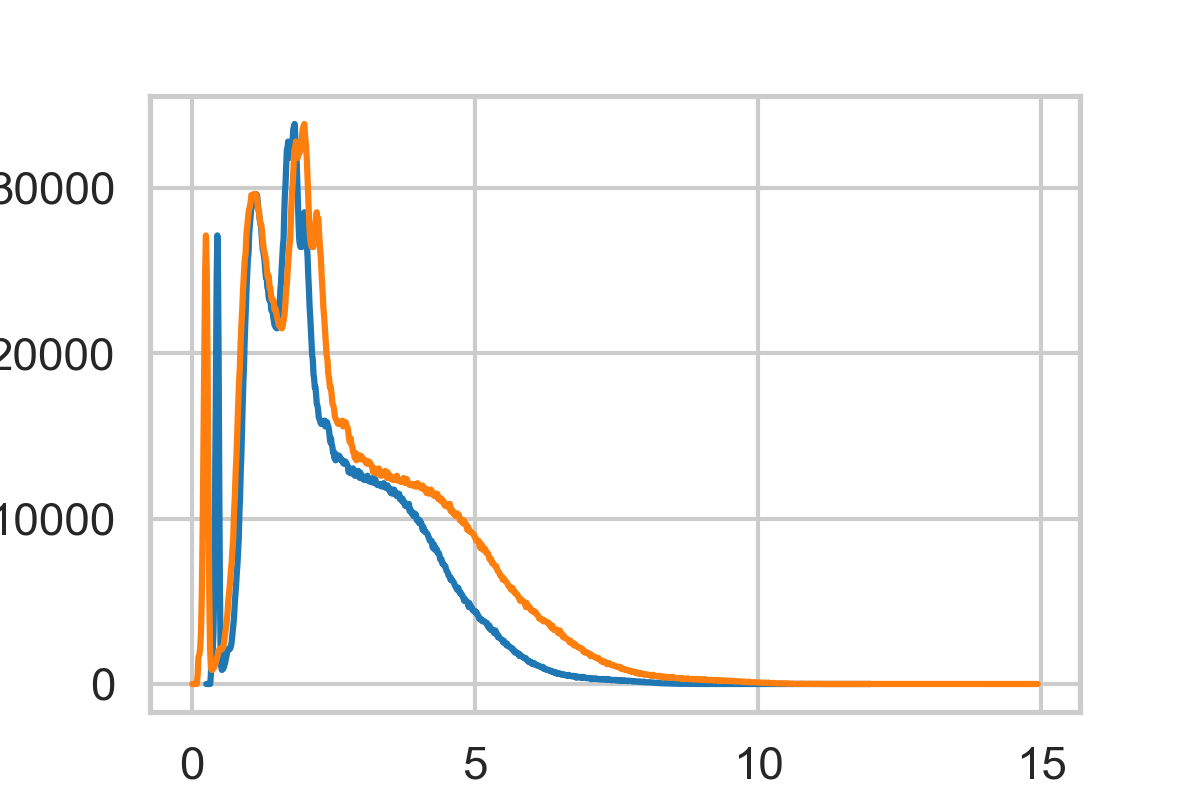

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(energ_lo, counts)
ax.plot(bin_lo, counts)

I'm going to continue working with energ_lo and energ_hi for use in models, since that's what we need to push through the response:

In [52]:
from sherpa.astro import xspec

In [53]:
xspec.get_xsversion()

'12.9.1m'

In [54]:
xspec.get_xschatter()

0

In [56]:
pl = xspec.XSpowerlaw()

In [90]:
pl.norm=10.0
pl.PhoIndex = 2.0

In [91]:
m = pl(energ_lo, energ_hi)

<IPython.core.display.Javascript object>


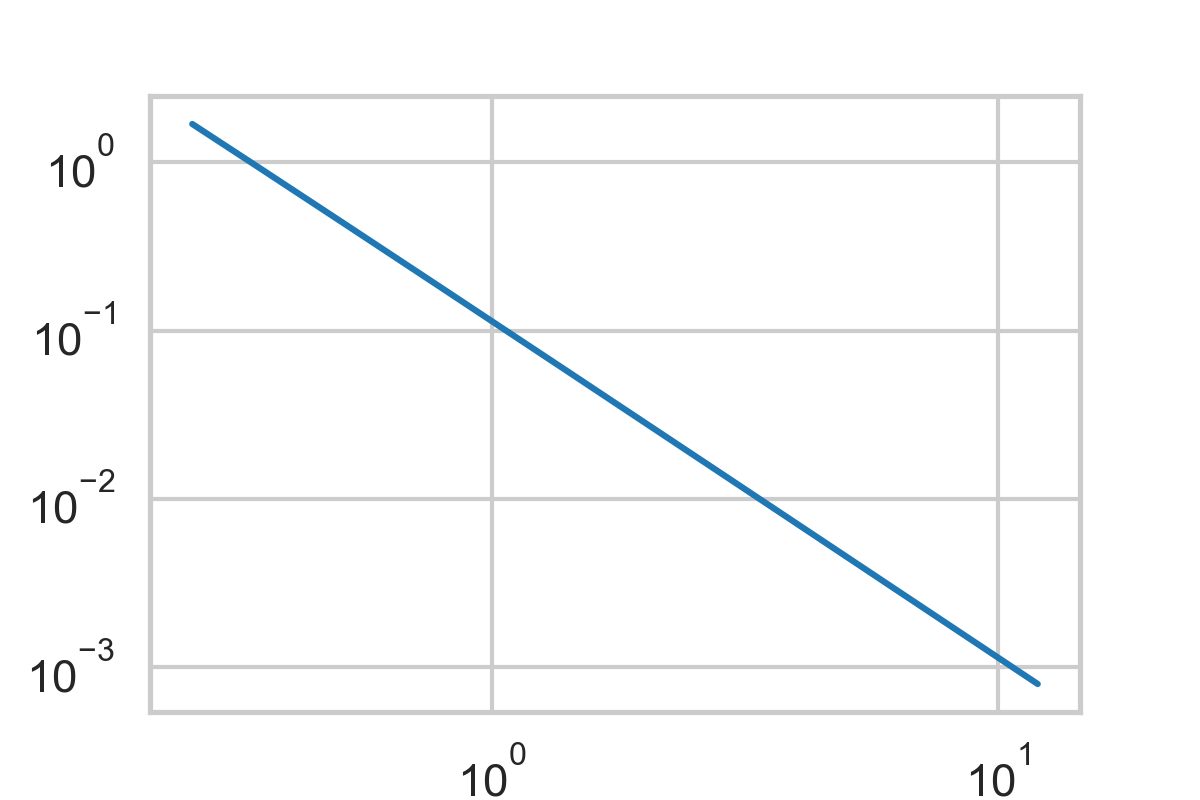

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(energ_lo, m)

Ok, cool! That worked! Let's now apply the response:

In [93]:
m_arf = arf.apply_arf(m)*exposure

<IPython.core.display.Javascript object>


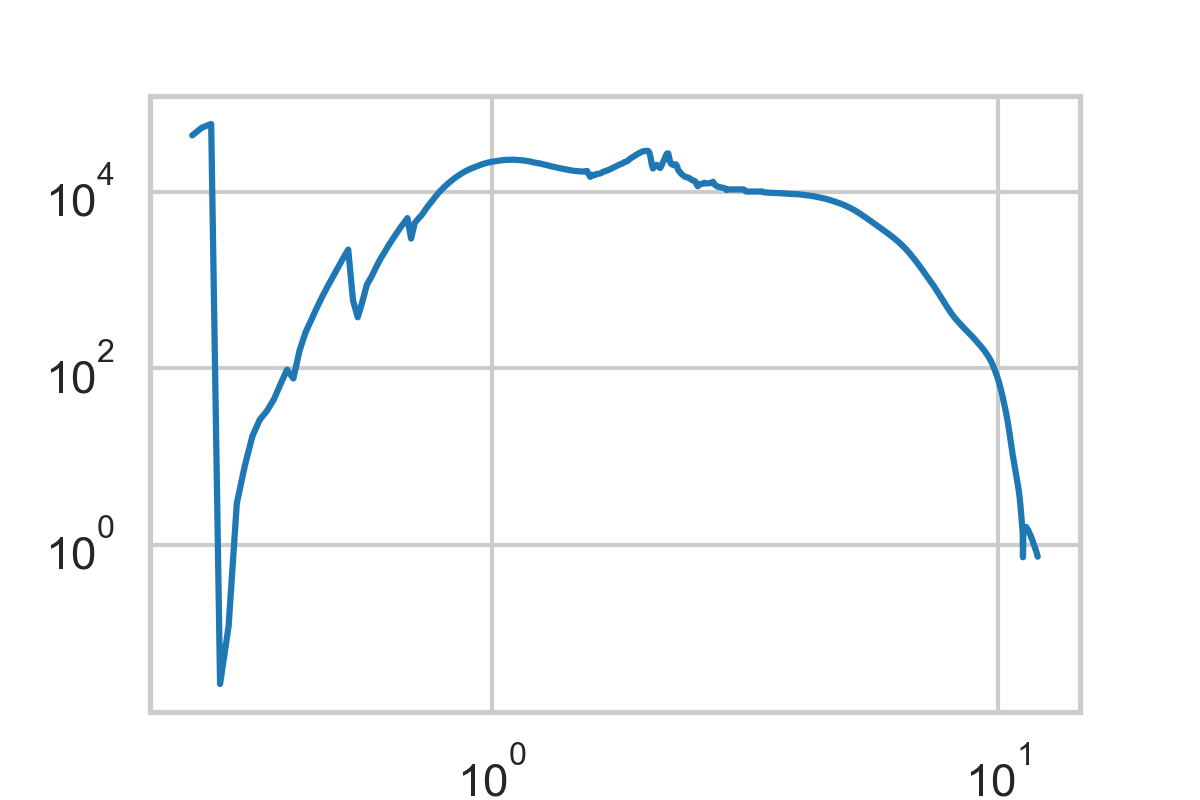

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(energ_lo, m_arf)

And now we also need to apply the rmf:

In [95]:
m_rmf = rmf.apply_rmf(m_arf)

<IPython.core.display.Javascript object>


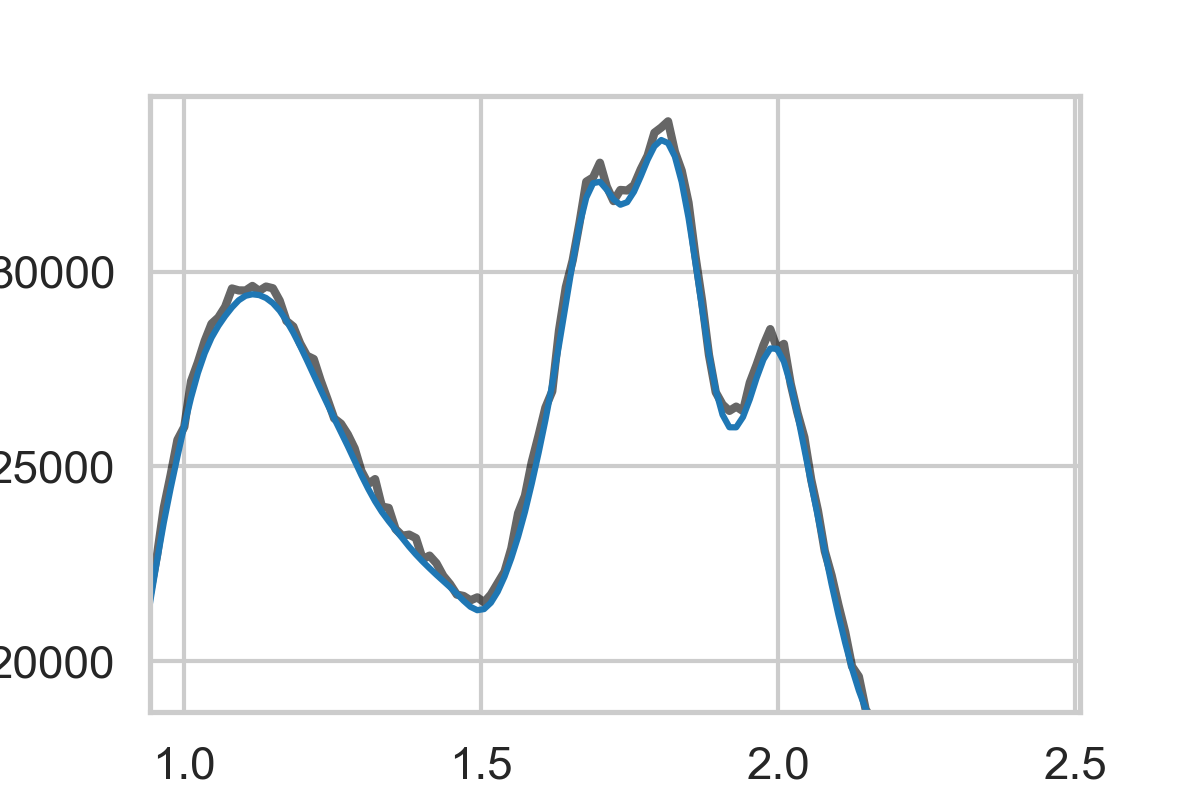

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(energ_lo, counts, color="black", lw=3, alpha=0.6)
ax.plot(energ_lo, m_rmf)

Hooray! That works!

### Simulating a spectrum with pile-up

Let's simulate a spectrum with pile-up based on the model above.

**Question**: Should pile-up be applied *before* the RMF calculation or *after*??

Let's assume after for now:

In [580]:
norm = 0.005 # input power law normalization
PhoIndex = 1.8 # input power law photon index (is negative by default)

We'll take the energy bins and the exposure from the ARF:

In [581]:
print(exposure)

9914.9001034498


In [582]:
energ_lo[:10]

array([0.255     , 0.26646972, 0.27793944, 0.28940919, 0.30087891,
       0.31234863, 0.32381836, 0.33528808, 0.3467578 , 0.35822755])

In [583]:
energ_hi[:10]

array([0.26646972, 0.27793944, 0.28940919, 0.30087891, 0.31234863,
       0.32381836, 0.33528808, 0.3467578 , 0.35822755, 0.36969727])

So, let's first simulate a model spectrum using the power law model:

In [584]:
pl = xspec.XSpowerlaw()
pl.norm = norm
pl.PhoIndex = PhoIndex

base_model = pl(energ_lo, energ_hi)

Ok, cool. Now we apply ARF and RMF (as we did above):

In [585]:
pl = xspec.XSpowerlaw()
pl.norm = norm
pl.PhoIndex = PhoIndex

base_model = pl(energ_lo, energ_hi)

base_arf = arf.apply_arf(base_model)*exposure
base_spec = rmf.apply_rmf(base_arf)

That's the basic spectrum we are going to compare to. 

Now we need to actually sample some photons. What's the integral of our new spectrum:

In [586]:
np.sum(base_spec)

3687.683737490902

**Question**: One thing to figure out is how to fold in the detector- and chip-dependent PSF. I might need to ask Lia for that? I think we need to draw from the energies and then from the PSF and then figure out whether photons within the same frame time also fall into the same/adjacent pixels.

For now, let's assume we're looking at a single pixel.

First, we need to decide the total number of photons we observe:

In [587]:
np.random.seed(200) # set the seed for reproducibility

In [588]:
nphot = np.random.poisson(np.sum(base_spec))

In [589]:
print("The total number of photons is %i"%nphot)

The total number of photons is 3821


Ok, cool. Let's assume our source is constant, in which case we can distribute our photons evenly in time:

In [590]:
tstart = 0
tend = tstart + exposure

phot_times = np.random.uniform(tstart, tend, size=nphot)

phot_times = np.sort(phot_times)

In the next step, we need to sample energies from the spectrum. There are several ways to do this. The most accurate one is to sample from the *inverse cumulative distribution function* of the distribution that produced the data. This distribution doesn't always exist (it does for the PSD, but not for some of the more complex numerical spectra out there). 

We're going to do the simple thing here: we're going to use the spectrum above as a cumulative distribution function and distribute photons into bins:

In [591]:
spec_pdf = base_spec/np.sum(base_spec)

In [592]:
phot_energies = np.random.choice(energ_lo, size=nphot, replace=True, p=spec_pdf)

<IPython.core.display.Javascript object>


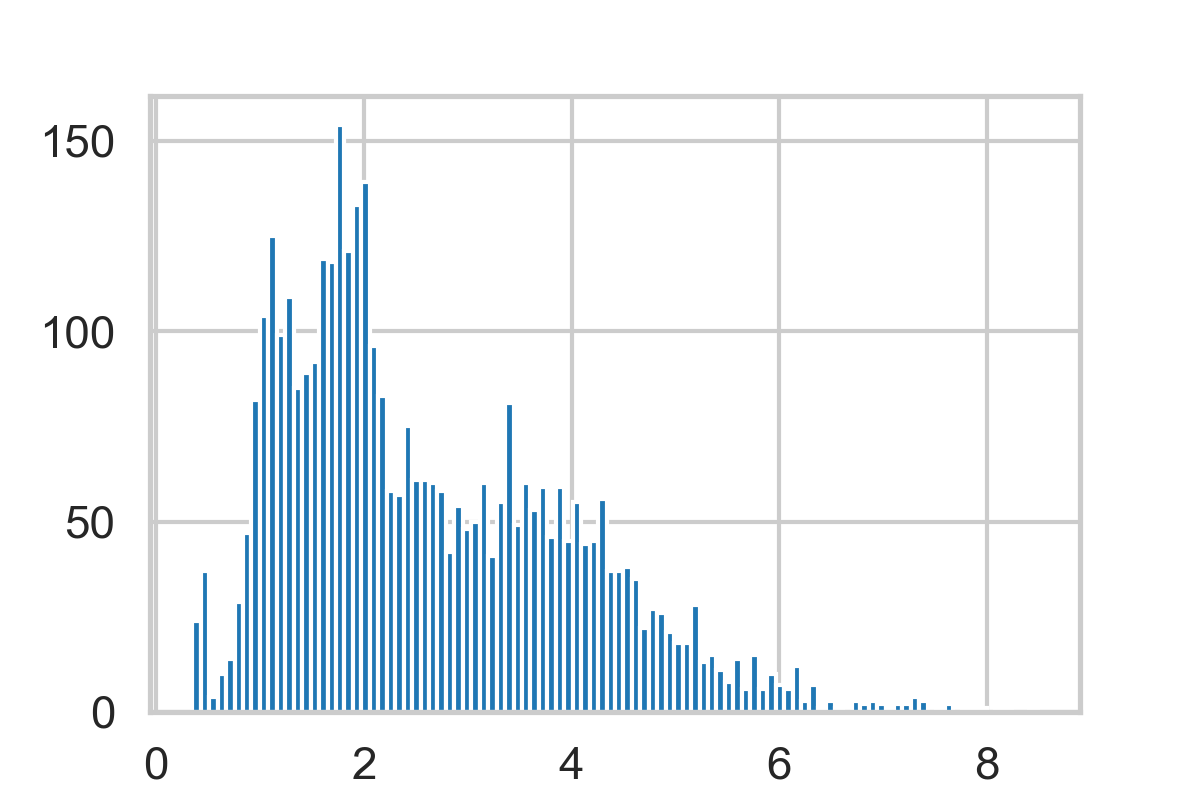

In [593]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(phot_energies, bins=100);

That looks vaguely correct. Let's now include the Chandra frame times:

In [594]:
frametime = 3.2 # frame read-out interval in seconds

We're going to build a set of intervals to sort our frame times into:

In [595]:
intervals = np.arange(tstart, tend+frametime, frametime)

Now we can sort out photons into these intervals and bin the energies. The function `scipy.stats.binned_statistic` does this quite neatly:

In [596]:
import scipy.stats

In [597]:
summed_erg, bins, bin_idx = scipy.stats.binned_statistic(phot_times, phot_energies, bins=intervals, statistic="sum")

In [598]:
n_per_bin = np.bincount(bin_idx-1) # bin_idx is one-indexed for reasons I don't understand!

Let's compare with the simple `numpy.histogram` on the times to make sure this works as expected:

In [599]:
phot_per_bin, bins2 = np.histogram(phot_times, bins=intervals)

In [600]:
n_per_bin[:10]

array([2, 3, 1, 0, 0, 1, 2, 2, 2, 0])

In [601]:
phot_per_bin[:10]

array([2, 3, 1, 0, 0, 1, 2, 2, 2, 0])

In [602]:
np.all(n_per_bin == phot_per_bin)

/Users/danielahuppenkothen/work/sw/miniconda3/envs/sherpa2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

Woo! This works. We now have a set of summed energies in `summed_erg`. Let's throw out everything that's above the upper end of `energ_hi` and 0 (those were frames with no photons):

In [603]:
summed_erg = summed_erg[(summed_erg > 0) & (summed_erg < np.max(energ_hi))]

In [604]:
energ_lo[1:10]

array([0.26646972, 0.27793944, 0.28940919, 0.30087891, 0.31234863,
       0.32381836, 0.33528808, 0.3467578 , 0.35822755])

In [605]:
energ_intervals = np.hstack([energ_lo, energ_hi[-1]])

In [606]:
spec_nopileup, spec_bins = np.histogram(phot_energies, bins=energ_intervals)
spec_pileup, spec_bins = np.histogram(summed_erg, bins=energ_intervals)

In [607]:
len(spec_nopileup)

1024

<IPython.core.display.Javascript object>


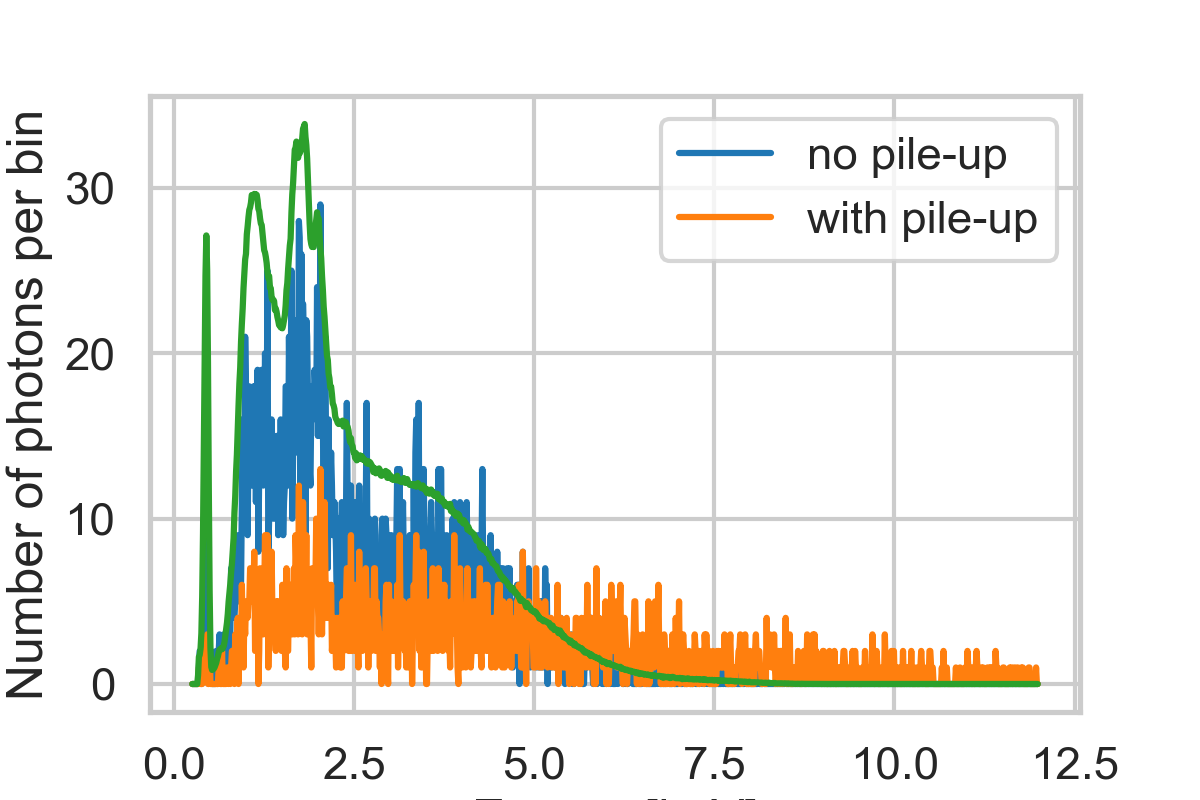

Text(0,0.5,'Number of photons per bin')

In [608]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(energ_lo, spec_nopileup, label="no pile-up")
ax.plot(energ_lo, spec_pileup, label="with pile-up")
ax.plot(energ_lo, d.counts/1000)
ax.legend()

ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Number of photons per bin")

Okay, so I just shifted *lots* of photons to higher energies and thrown a bunch out. 

Let's calculate the pile-up fraction. There are several ways to calculate the pile-up fraction. Here, we're going to calculate the number of frames that have been piled up:

**TODO**: Check with Lia about best definition of the pile-up fraction!

In [609]:
pileup_fraction = len(n_per_bin[n_per_bin > 1])/len(n_per_bin)

In [610]:
print("%.2f of the frames have piled events in them."%pileup_fraction)

0.34 of the frames have piled events in them.


That's a lot of pile-up!

## Fitting the Spectrum

I now want to see if I can fit the spectrum. Let's make copies of the original (simulated) spectrum and store my newly produced counts array in them:

In [611]:
import copy 

In [612]:
d_sim = copy.deepcopy(d)

In [613]:
d_sim.counts = spec_nopileup

In [614]:
d_pileup = copy.deepcopy(d)

In [615]:
d_pileup.counts = spec_pileup

Now I can set up the likelihood and do optimization and/or sampling:

In [616]:
import scipy.optimize
import emcee
import corner

In [617]:
from scipy.special import gammaln

In [618]:
class PoissonLogLikelihood(object):
    def __init__(self, spec, model):
        self.spec = spec
        self.model = model
        
        self.arf = self.spec.get_arf()
        self.rmf = self.spec.get_rmf()
        
        # calculate log-counts here for the likelihood
        # makes things slightly faster
        self.sum_log_counts = gammaln(self.spec.counts+1)        
        return
    
    def _create_model_spectrum(self, pars):
        
        # get the right parameters out of the list
        # BEWARE: This currently only works for the Power law model!!!
        
        try:
            norm = pars[0]
            phoindex = pars[1]
            # set parameters in the model with those in the parameter list
            self.model.norm = norm
            self.model.PhoIndex = phoindex

            # model spectrum in intensity units
            mm = self.model(self.arf.energ_lo, self.arf.energ_hi)

            # apply ARF
            model_arf = self.arf.apply_arf(mm)*self.arf.exposure
            # apply RMF
            model_spec = self.rmf.apply_rmf(model_arf)

            return model_spec

        except sherpa.models.parameter.ParameterErr:
            return -np.inf
        
    
    def evaluate(self, pars):
    
        # get a model spectrum, with ARF and RMF applied:
        model_spec = self._create_model_spectrum(pars)
        
        ## NOTE: THIS IS A HACK! NEED TO TALK TO SOMEONE WITH 
        ## MORE X-RAY SPECTROSCOPY EXPERIENCE TO FIGURE OUT 
        ## WHAT TO DO WITH ZERO FLUXES!!!
        #mask = (model_spec > 0)
        
                
        # now define Poisson log-likelihood:
        #loglike = np.sum(-model_spec[mask] + 
        #                 self.spec.counts[mask] * np.log(model_spec[mask]) + 
        #                 self.sum_log_counts[mask])
        
        model_spec += 1e-10
        
        loglike = np.sum(-model_spec + 
                         self.spec.counts * np.log(model_spec) + 
                         self.sum_log_counts)


                # if log-likelihood is not finite, make it -infinity
        if not np.isfinite(loglike):
            loglike = -np.inf
            
        return loglike
    
    def __call__(self, pars):
        return self.evaluate(pars)

Let's try it:

In [619]:
loglike = PoissonLogLikelihood(d_sim, pl)

In [623]:
loglike([0.005, 1.8])

10365.531256785443

In [626]:
test_model = loglike._create_model_spectrum([0.005, 1.8])

<IPython.core.display.Javascript object>


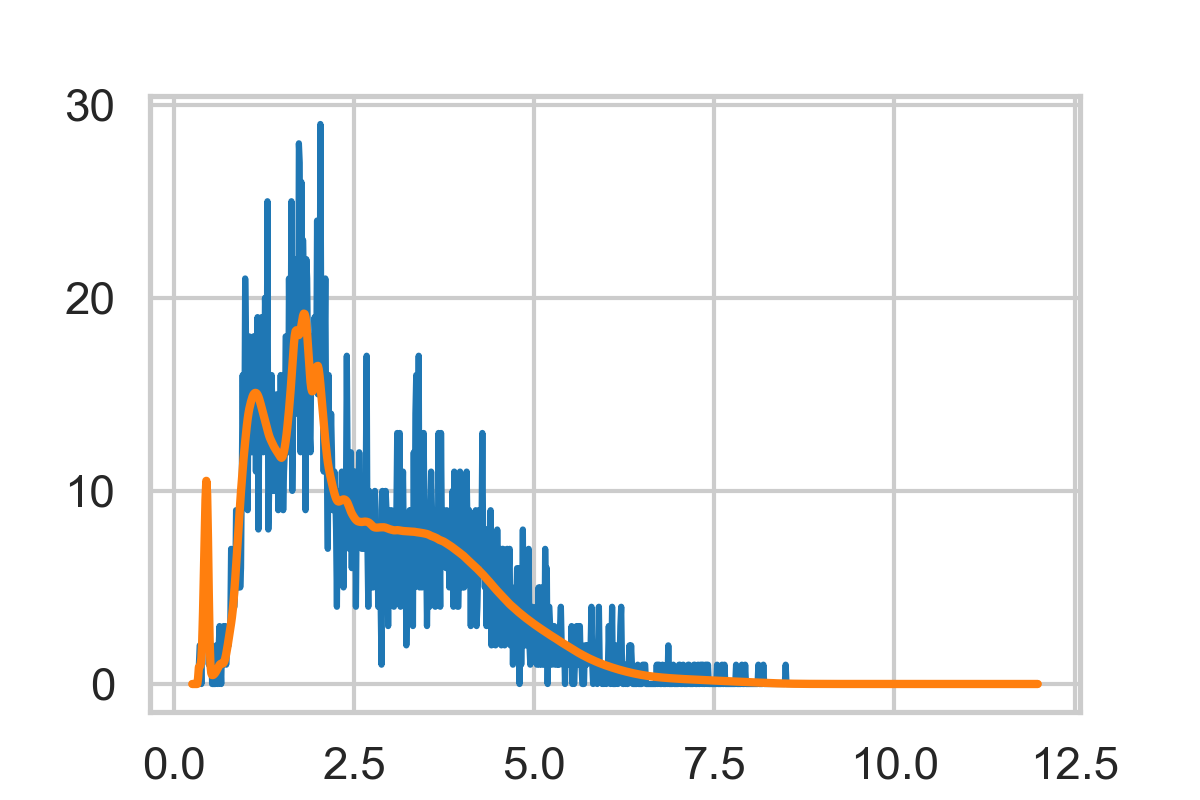

In [627]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(loglike.arf.energ_lo, loglike.spec.counts)
ax.plot(loglike.arf.energ_lo, test_model, lw=3)

Okay, cool, that gives me a value! Now let's try to do some optimization. First, I need to define a function for the negative log-likelihood:

In [628]:
neg_log_like = lambda pars: -loglike(pars)

In [629]:
neg_log_like([0.005, 2.0])

-10257.504755683183

That works! Let's set up the fitter:

In [630]:
true_pars = [0.005, 1.8]

start_pars = [0.02, 1.7]

In [631]:
neg_log_like(start_pars)

-3470.571548015493

In [632]:
neg_log_like(true_pars)

-10365.531256785443

In [633]:
res = scipy.optimize.minimize(neg_log_like, start_pars, bounds = [[0.001, 1.0], [-2.0, 5.0]], method="L-BFGS-B")

In [634]:
res

      fun: -10368.005784090607
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00291038, -0.0001819 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 9
   status: 0
  success: True
        x: array([0.00523465, 1.81103905])

Hooray! That seems to do the right thing! Let's plot the result:

<IPython.core.display.Javascript object>


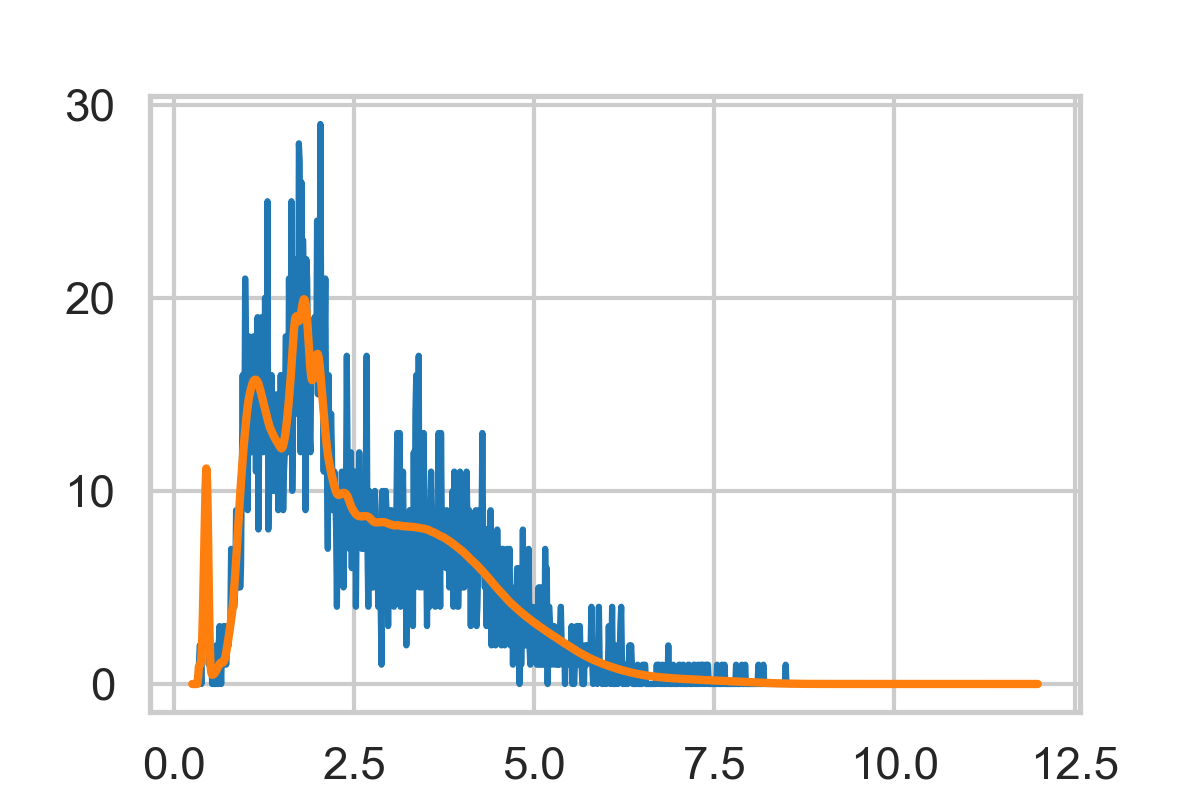

In [635]:
test_model = loglike._create_model_spectrum(res.x)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(loglike.arf.energ_lo, loglike.spec.counts)
ax.plot(loglike.arf.energ_lo, test_model, lw=3)

Now we can do the same thing with the piled-up spectrum:

In [636]:
loglike_pileup = PoissonLogLikelihood(d_pileup, pl)
neg_log_like_pileup = lambda pars: -loglike_pileup(pars)

In [637]:
neg_log_like_pileup(true_pars)

1775.319845334017

In [638]:
res = scipy.optimize.minimize(neg_log_like_pileup, start_pars, bounds = [[0.00001, 1.0], [-2.0, 5.0]], method="L-BFGS-B")

In [639]:
res

      fun: 853.2679654204353
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.5054428e+01, -2.9444891e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 14
   status: 0
  success: True
        x: array([0.0006007 , 0.48376363])

<IPython.core.display.Javascript object>


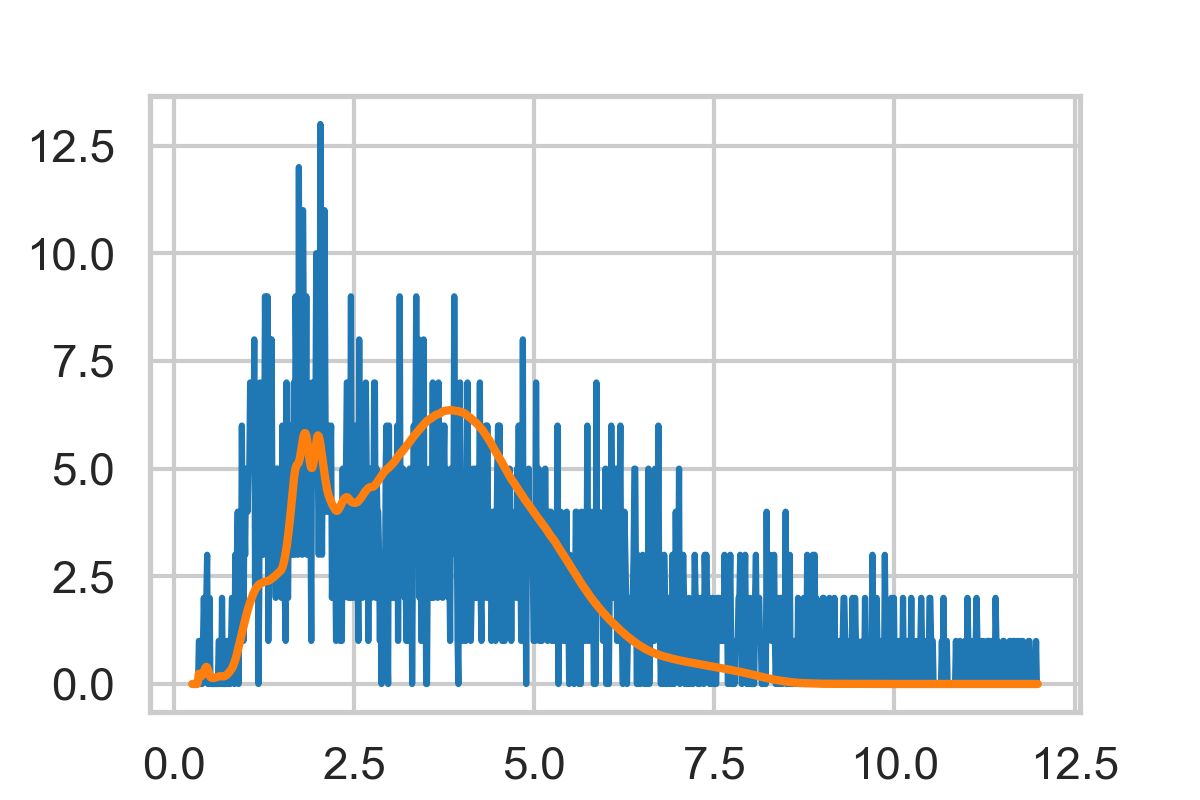

In [640]:
test_model = loglike_pileup._create_model_spectrum(res.x)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(loglike_pileup.arf.energ_lo, loglike_pileup.spec.counts)
ax.plot(loglike_pileup.arf.energ_lo, test_model, lw=3)

### Implementing MCMC

Let's run MCMC on the same problem. All we need for that are some priors:

In [751]:
class PoissonLogPosterior(object):
    def __init__(self, spec, model):
        self.spec = spec
        self.model = model
        
        self.arf = self.spec.get_arf()
        self.rmf = self.spec.get_rmf()
        
        # calculate log-counts here for the likelihood
        # makes things slightly faster
        self.sum_log_counts = gammaln(self.spec.counts+1)    
        
        # set the log-likelihood:
        self.loglikelihood = PoissonLogLikelihood(spec, model)
        
        return

    def logprior(self, pars):
        
        # log-prior for power law model ONLY.
        log_norm = pars[0]
        phoindex = pars[1]
        
        # above -3, basically all photons will be piled out of 
        # the observable energy range
        p_lognorm = scipy.stats.uniform(-10, 7).logpdf(log_norm)
        
        p_phoindex = scipy.stats.uniform(-2, 5).logpdf(phoindex)
        
        return p_lognorm + p_phoindex
    
    def logposterior(self, pars):
        # note that I've defined the prior for the normalization in 
        # log-space, so I need to exponentiate that for calculating 
        # the log-likelihood correctly
        loglike_pars = [np.exp(pars[0]), pars[1]]
        
        return self.loglikelihood(loglike_pars) + self.logprior(pars)
    
    def __call__(self, pars):
        return self.logposterior(pars)


In [752]:
lpost = PoissonLogPosterior(d_sim, pl)

In [753]:
true_pars_lpost = [np.log(true_pars[0]), true_pars[1]]

In [754]:
true_pars_lpost

[-5.298317366548036, 1.8]

In [755]:
lpost(true_pars_lpost)

10361.975908723954

Let's try one that's outside the prior range for the normalization:

In [756]:
lpost([-14, 1.5])

-inf

Let's also try one that's outside the prior range for the photon index:

In [757]:
lpost([np.log(0.01), 6.1])

-inf

Ok, cool. Let's fit the posterior as well:

In [758]:
neg_lpost = lambda pars: -lpost(pars)

In [759]:
res = scipy.optimize.minimize(neg_lpost, [np.log(0.1), 1.4], method="L-BFGS-B")

In [760]:
res

      fun: inf
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([nan, nan])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([-2.30258509,  1.4       ])

In [761]:
np.exp(-4.58)

0.010254896296404022

Hooray, that looks right as well! What about the piled-up spectrum?

In [764]:
lpost_pileup = PoissonLogPosterior(d_pileup, pl)
neg_lpost_pileup = lambda pars: -lpost_pileup(pars)

res_pileup = scipy.optimize.minimize(neg_lpost_pileup, [np.log(0.001), 1.4], method="L-BFGS-B")

In [765]:
res_pileup

      fun: 856.8233133656092
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00015916,  0.00022737])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([-7.41742078,  0.48376295])

That seems to work as well.

Now we can set up our MCMC sampler:

In [766]:
nwalkers = 100 # number of MCMC walkers
burnin = 1000 # number of burn-in steps

ndim = len(true_pars) # number of parameters

niter = 1000 # number of iterations in production

sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)

In [767]:
p0 = np.random.multivariate_normal(res.x, np.array(res.hess_inv.todense()), size=nwalkers)

In [768]:
pos, prob, state = sampler.run_mcmc(p0, burnin)

In [769]:
sampler.chain.shape

(100, 1000, 2)

<IPython.core.display.Javascript object>


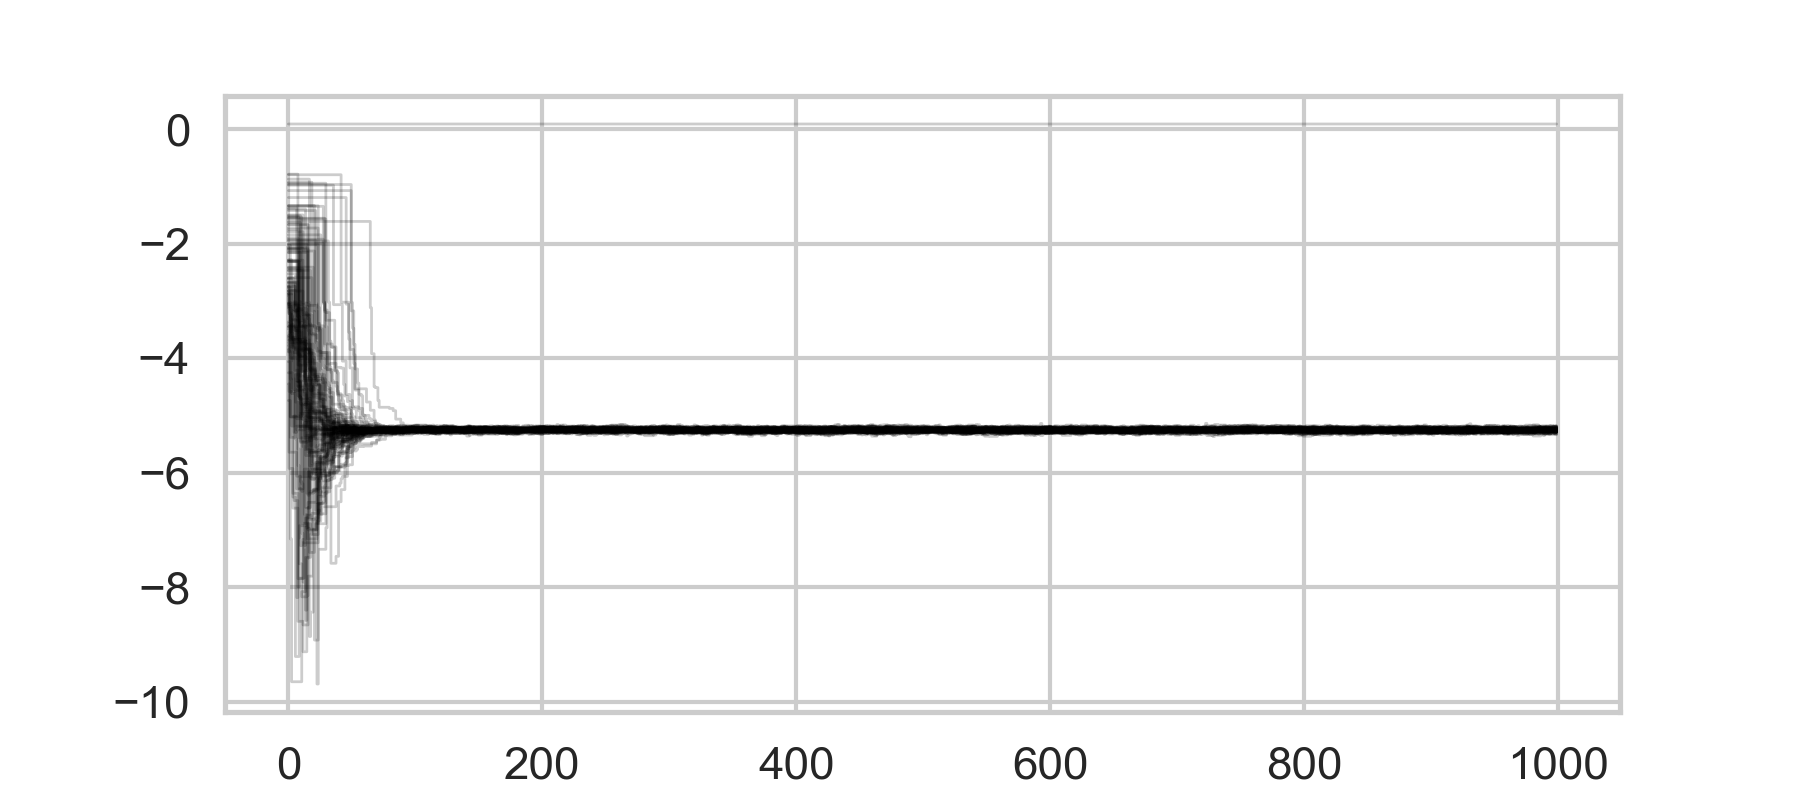

<IPython.core.display.Javascript object>


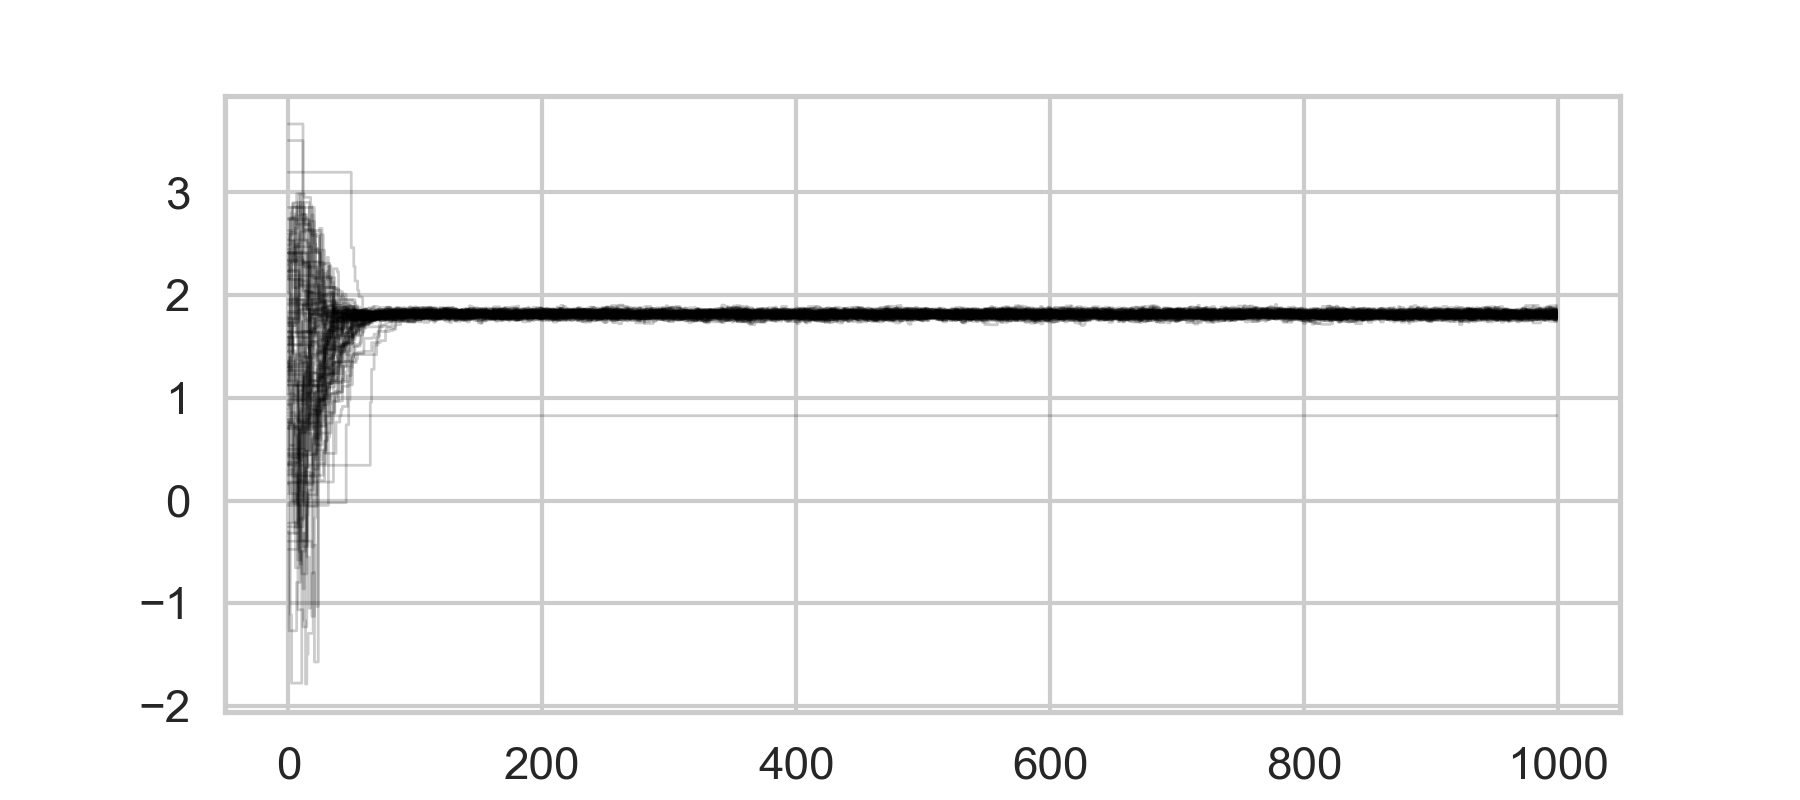

In [770]:
for i in range(ndim):
    fig, ax = plt.subplots(1, 1, figsize=(9,4))
    plt.plot(sampler.chain[:,:,i].T, lw=1, color='black', linestyle="steps-mid", alpha=0.2)

<IPython.core.display.Javascript object>


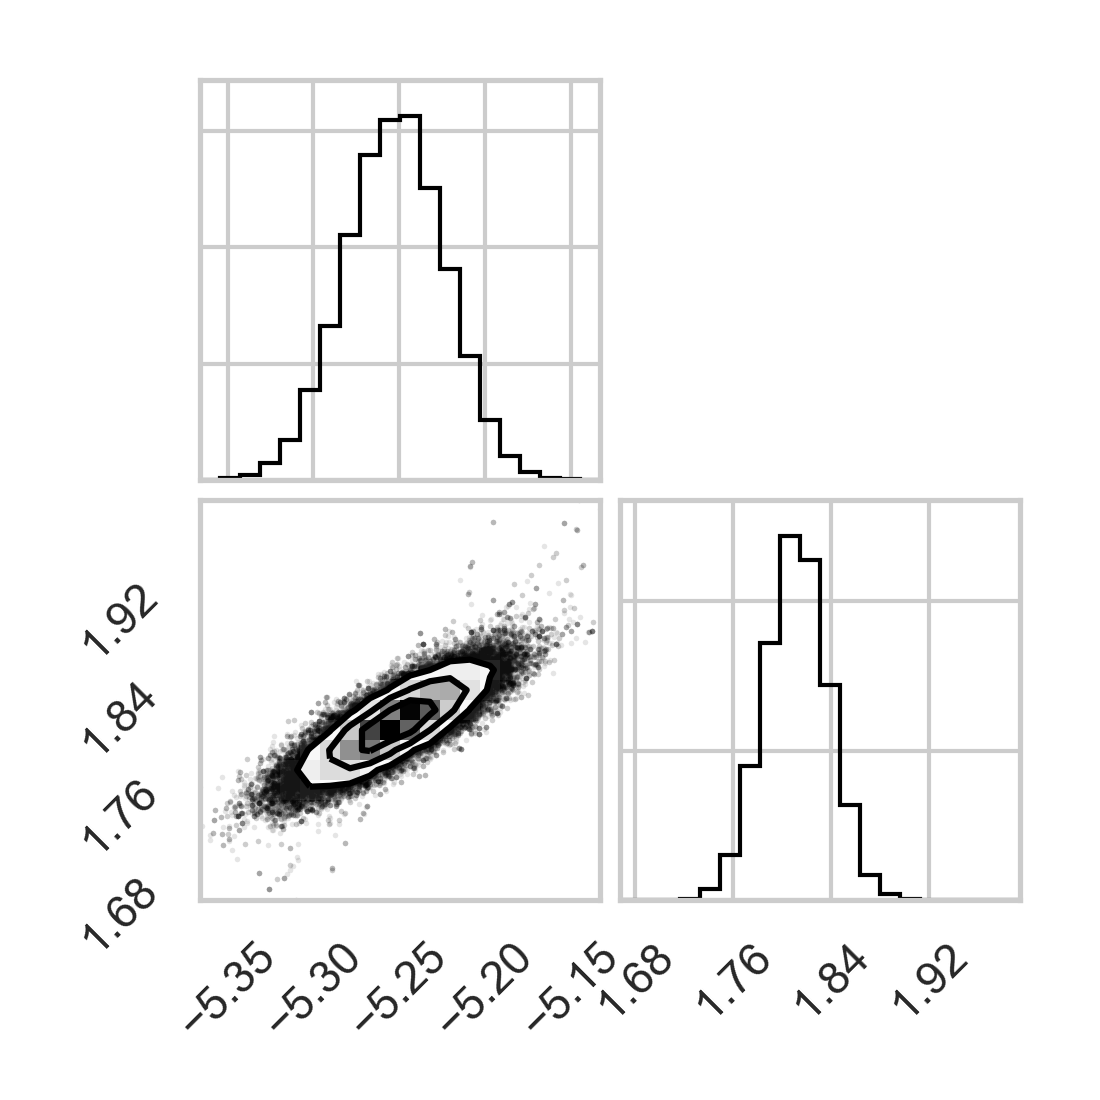

<IPython.core.display.Javascript object>


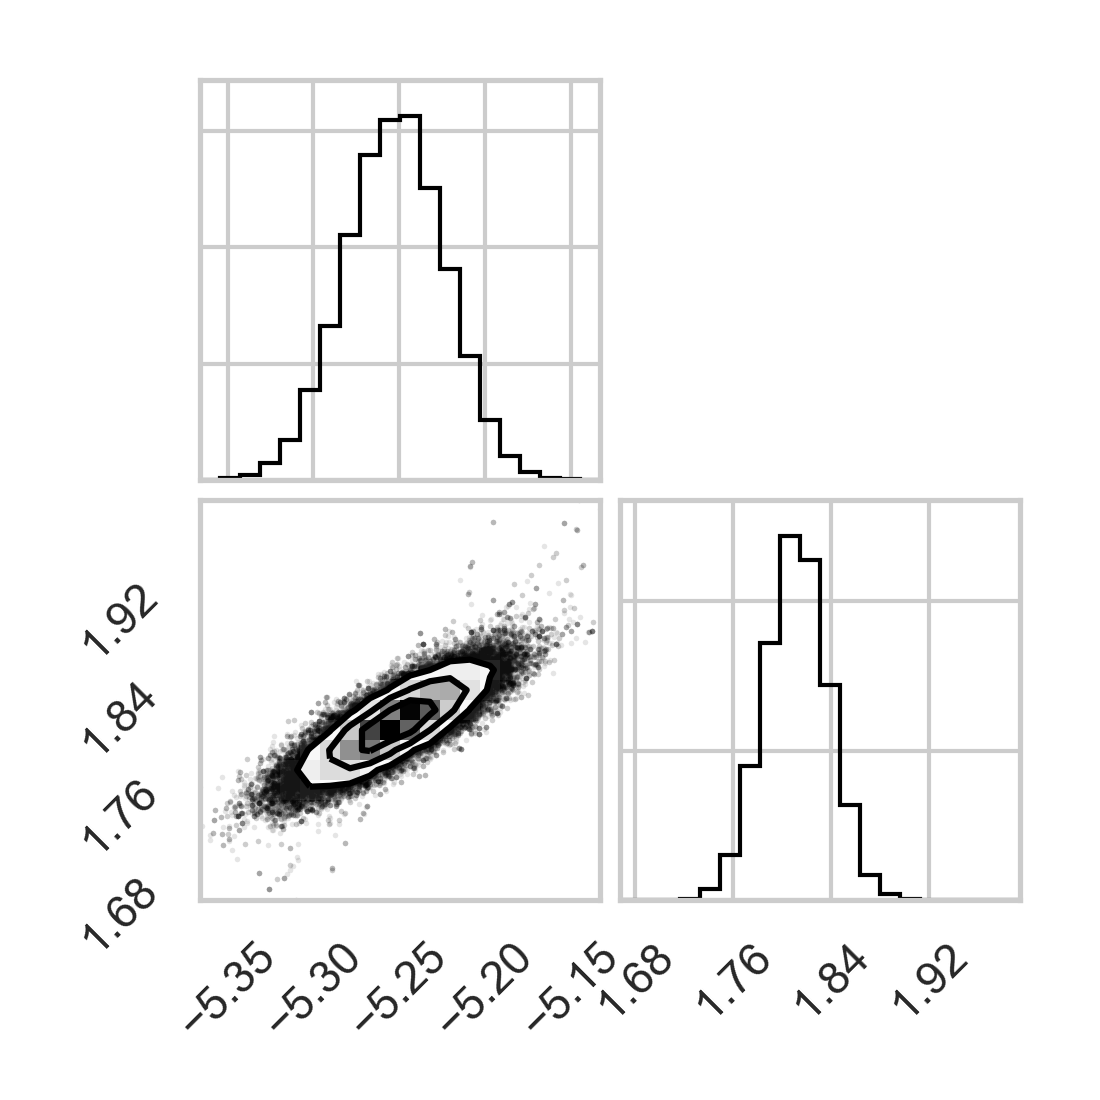

In [660]:
corner.corner(sampler.flatchain)

Let's run the same on the pile-up affected data:

In [771]:
nwalkers = 100 # number of MCMC walkers
burnin = 1000 # number of burn-in steps

ndim = len(true_pars) # number of parameters

niter = 1000 # number of iterations in production

sampler_pileup = emcee.EnsembleSampler(nwalkers, ndim, lpost_pileup)

In [772]:
p0 = np.random.multivariate_normal(res_pileup.x, np.array(res_pileup.hess_inv.todense()), size=nwalkers)
pos, prob, state = sampler_pileup.run_mcmc(p0, burnin)

In [773]:
sampler_pileup.reset()

In [774]:
pos, prob, state = sampler_pileup.run_mcmc(pos, niter, rstate0=state)

<IPython.core.display.Javascript object>


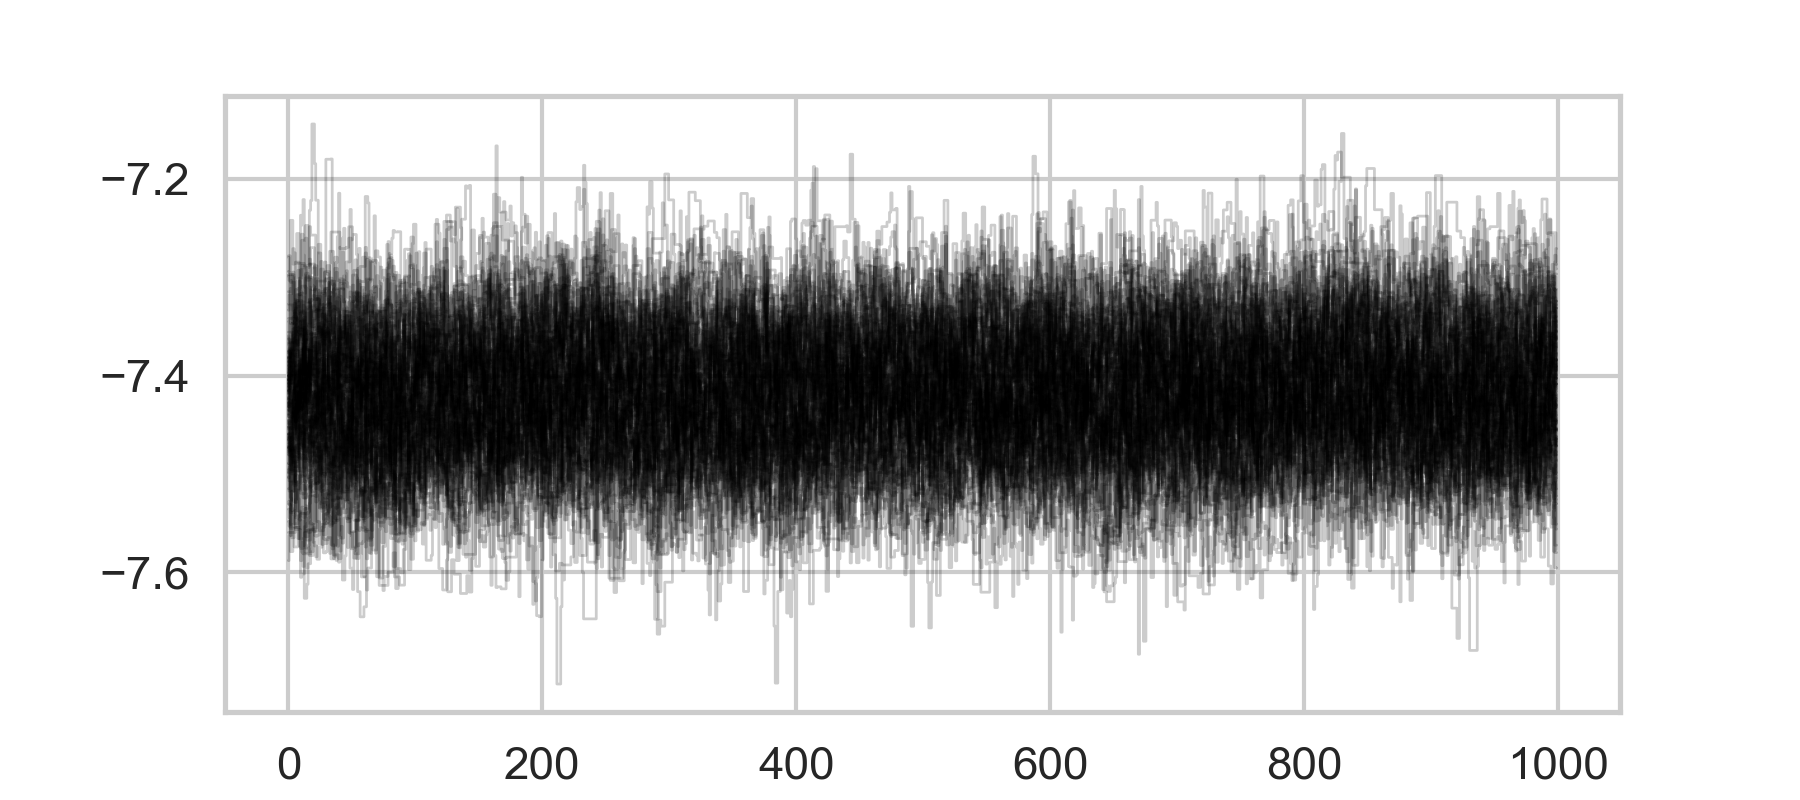

<IPython.core.display.Javascript object>


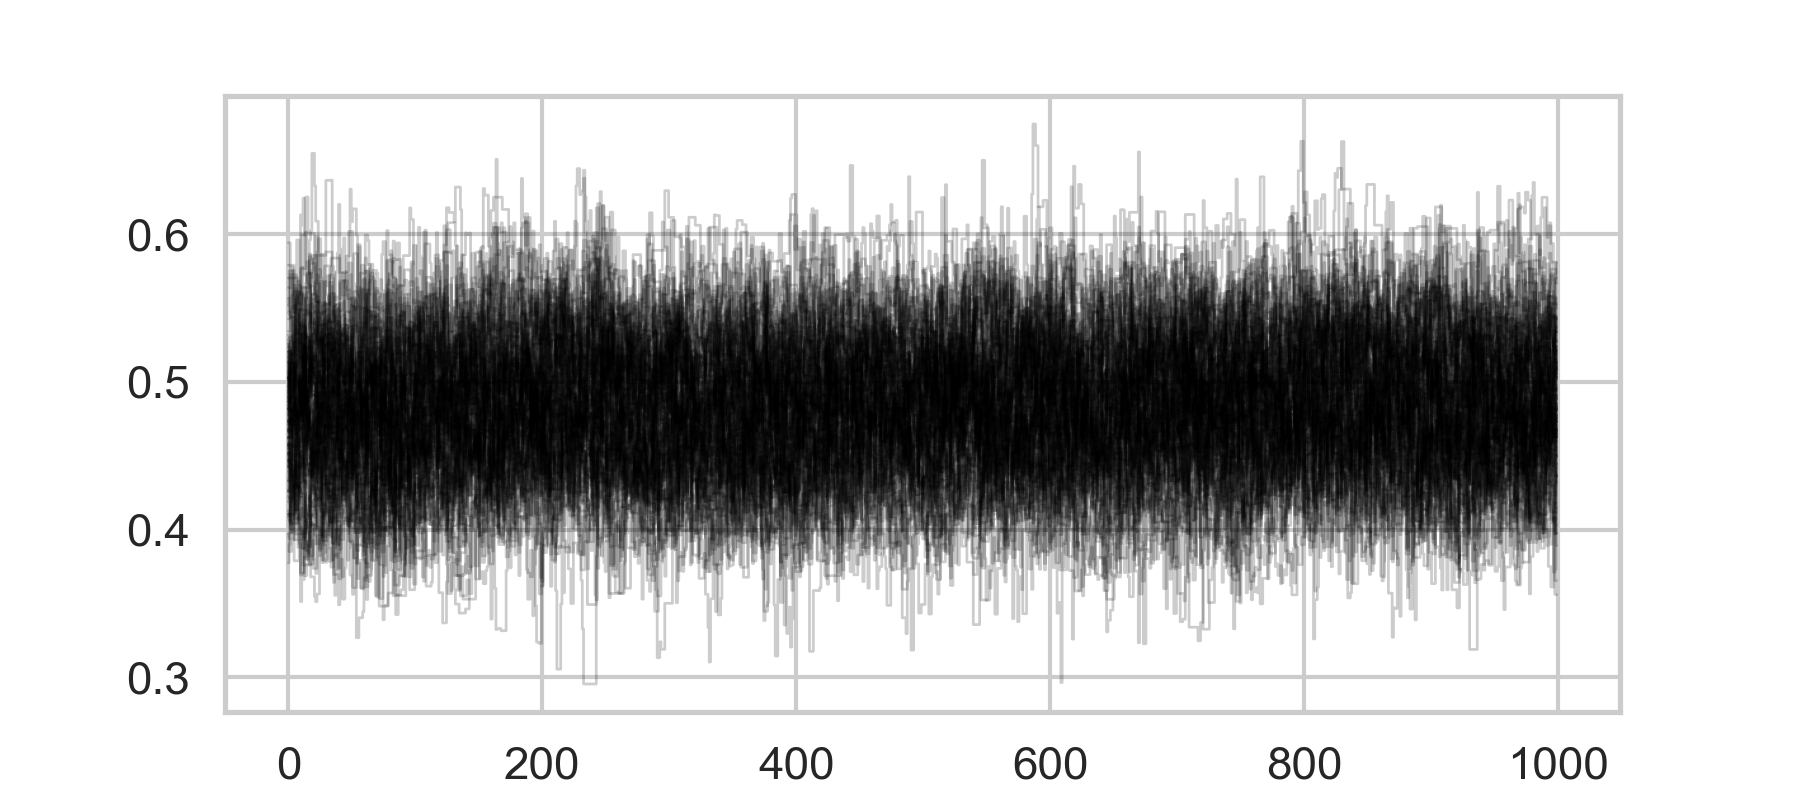

In [671]:
for i in range(ndim):
    fig, ax = plt.subplots(1, 1, figsize=(9,4))
    plt.plot(sampler_pileup.chain[:,:,i].T, lw=1, color='black', linestyle="steps-mid", alpha=0.2)

In [775]:
true_pars_lpost = [np.log(0.005), 1.8]

<IPython.core.display.Javascript object>


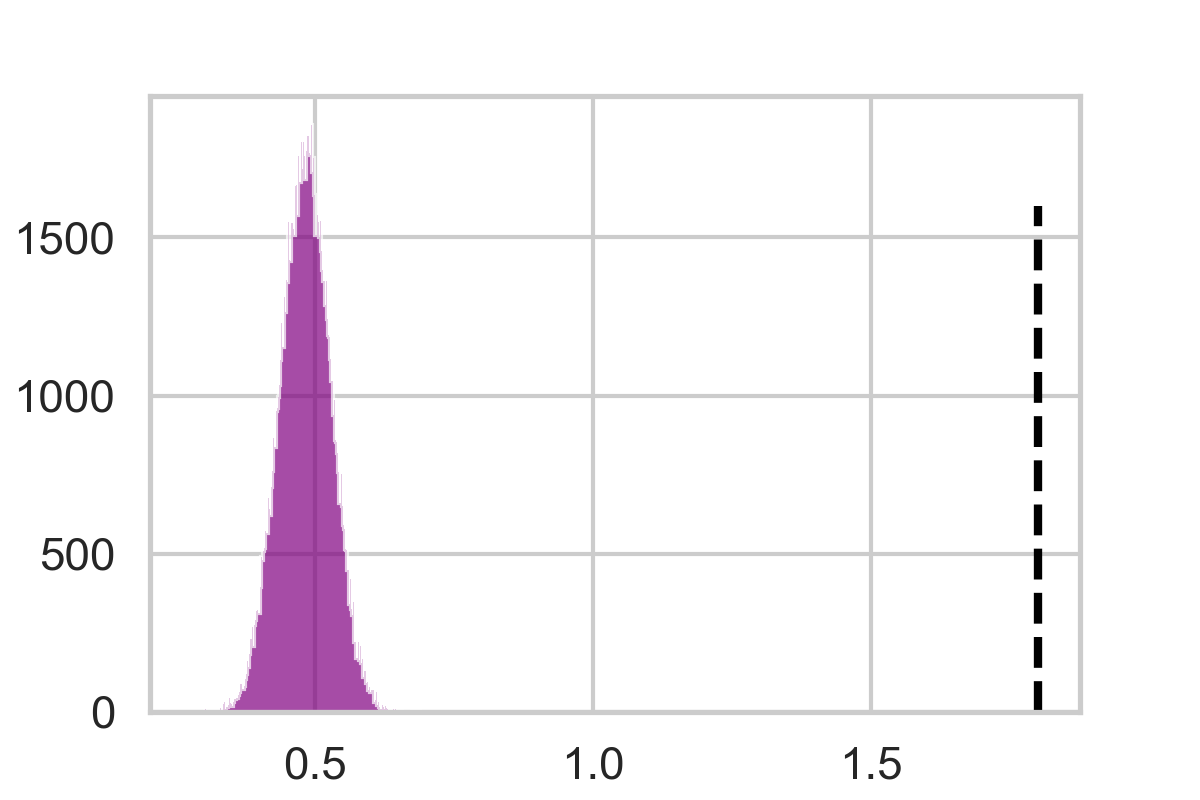

In [776]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(sampler_pileup.flatchain[:,1], bins=200, color="purple", alpha=0.7, histtype="stepfilled")
ax.vlines(true_pars_lpost[1], 0, 1600, lw=3, color="black", linestyle="dashed")

Ok, that looks horrible, just like I expected. 

### Pile-up Simulations

Let's see if we can do some simple ABC on this. For this, we're going to take some of the code above and make it into a function:

In [777]:
def simulate_pileup_spec(pars, energ_lo, energ_hi, arf, rmf, frametime=3.2, exposure=1.0, tstart=0.0):
    
    # set up the XSPEC model and parameters
    pl = xspec.XSpowerlaw()
    pl.norm = np.exp(pars[0])
    pl.PhoIndex = pars[1]

    # calculate the base model intensities
    base_model = pl(energ_lo, energ_hi)

    # apply ARF adn RMF
    base_arf = arf.apply_arf(base_model)*exposure
    base_spec = rmf.apply_rmf(base_arf)

    # get the number of photons from a Poisson distribution
    nphot = np.random.poisson(np.sum(base_spec))

    # get the end time for the exposure
    tend = tstart + exposure

    # get the photon arrival times for a constant light curve
    phot_times = np.random.uniform(tstart, tend, size=nphot)
    
    # sort the photon arrival times
    phot_times = np.sort(phot_times)
    
    # normalize the probability density function for the spectrum
    spec_pdf = base_spec/np.sum(base_spec)
    
    # get photon energies for each photon arrival time
    phot_energies = np.random.choice(energ_lo, size=nphot, replace=True, p=spec_pdf)

    # calculate the read-out intervals, starting with the start time of the exposure
    intervals = np.arange(tstart, tend+frametime, frametime)
    
    # bin the energies according to the intervals, sum up the photon energies in eaach frame
    summed_erg, bins, bin_idx = scipy.stats.binned_statistic(phot_times, phot_energies, 
                                                             bins=intervals, statistic="sum")
    
    # only include bins where the energy is greater than zero
    # and within the bounds of the spectrum
    summed_erg = summed_erg[(summed_erg > 0) & (summed_erg < np.max(energ_hi))]
    
    # get the energy intervals in a form that I can stick them into a 
    # histogram frunction
    energ_intervals = np.hstack([energ_lo, energ_hi[-1]])

    # calculate the piled-up spectrum in counts/bin
    spec_pileup, spec_bins = np.histogram(summed_erg, bins=energ_intervals)
    
    return spec_bins, spec_pileup


 Let's try it!

In [778]:
sim_bins, sim_spec = simulate_pileup_spec([-3.5, 1.5], energ_lo, energ_hi, arf, rmf, exposure=1e4)

<IPython.core.display.Javascript object>


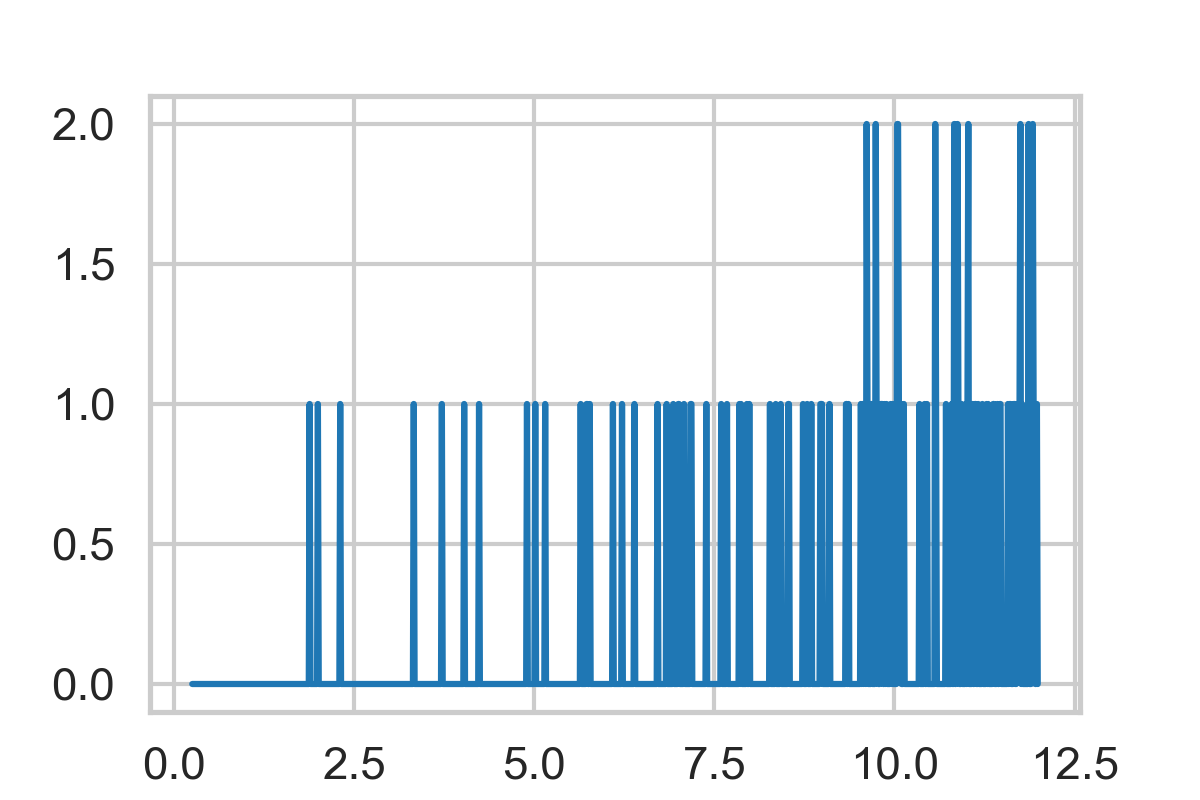

In [779]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(energ_lo, sim_spec)

Ok, cool. Let's simulate some spectra that have the same parameters as the "real" data:

In [780]:
true_pars_lpost

[-5.298317366548036, 1.8]

In [781]:
# number of simulated spectra
nsims = 1000

# make an empty array for the simulations
sim_spec_all = np.zeros((nsims, len(sim_spec)))

for i in range(nsims):
    sim_bins, sim_spec = simulate_pileup_spec(true_pars_lpost, energ_lo, energ_hi, arf, rmf, exposure=1e4)
    sim_spec_all[i,:] = sim_spec
    

<IPython.core.display.Javascript object>


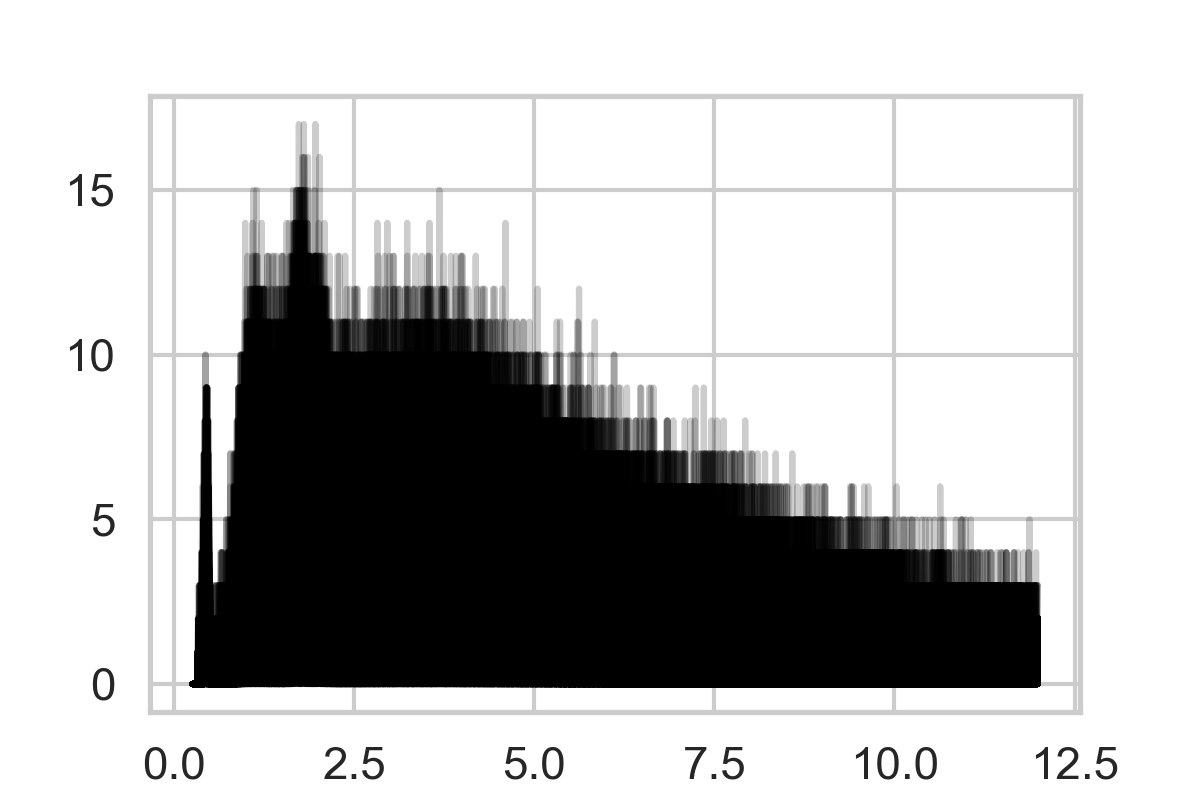

In [785]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(energ_lo,sim_spec_all.T, c="black", alpha=0.2);

ok, Cool. That looks vaguely right.

### Metrics

Let's think about some simple metrics for comparing spectra.


#### Euclidean Distance

Simple idea: use a Euclidean distance:

In [798]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2.))

In [799]:
euclidean_distance(lpost_pileup.spec.counts, sim_spec_all[0])

65.07687761409578

In [803]:
e_dist_true = np.zeros(nsims)

for i in range(nsims):
    e_dist_true[i] = euclidean_distance(lpost_pileup.spec.counts, sim_spec_all[i])
    

<IPython.core.display.Javascript object>


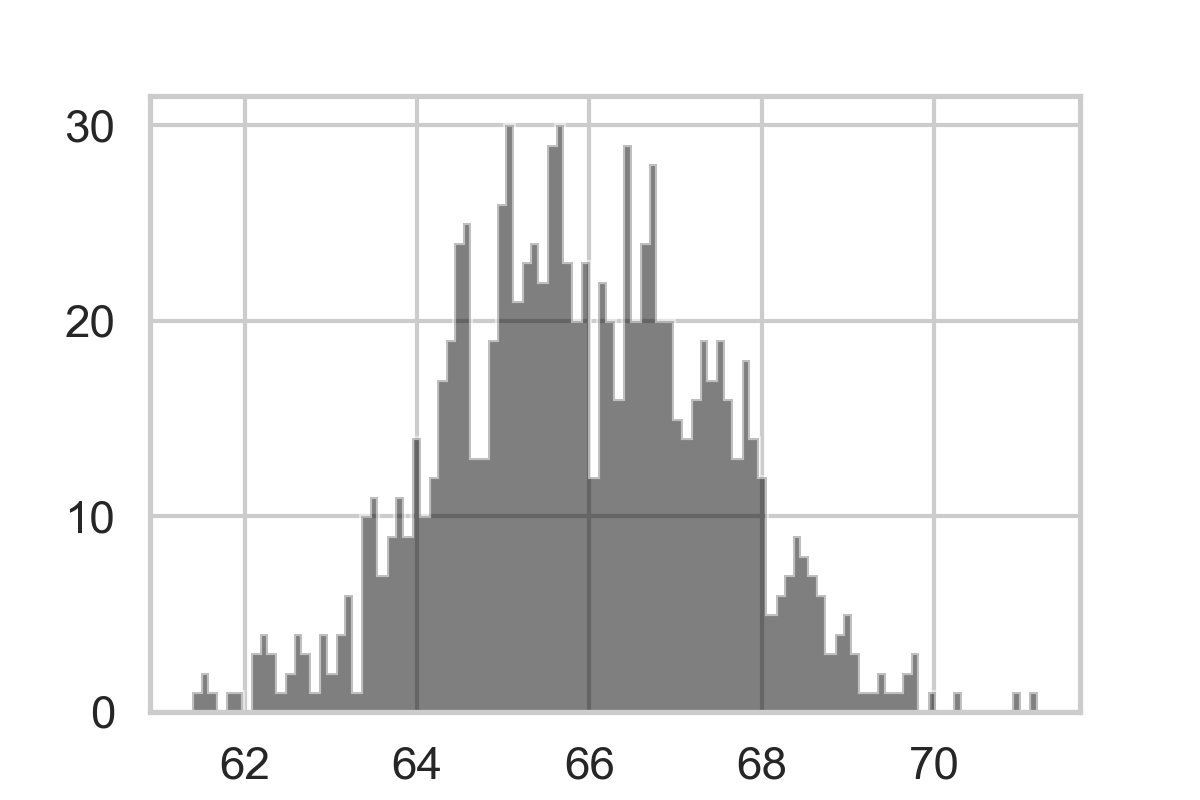

In [804]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(e_dist_true, bins=100, histtype="stepfilled", color="black", alpha=0.5);

Great. Let's do the same when sampling from the prior.

**Note**: This uses the specific prior implemented above for the power law we've been using:

In [813]:
%timeit scipy.stats.uniform(-10, 7).rvs()

461 µs ± 4.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [814]:
%timeit np.random.uniform(-10, -3)

613 ns ± 3.31 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [815]:
def from_prior():
    lognorm = np.random.uniform(-10, -3)
    phoindex = np.random.uniform(-2, 3)
    
    return [lognorm, phoindex]

In [816]:
e_dist_prior = np.zeros(nsims)
prior_pars_all = np.zeros((nsims, ndim))
sim_spec_prior = np.zeros((nsims, len(sim_spec)))

for i in range(nsims):
    p = from_prior()
    prior_pars_all[i] = p
    
    sim_bins, sim_spec = simulate_pileup_spec(p, energ_lo, energ_hi, arf, rmf, exposure=1e4)
    e_dist_prior[i] = euclidean_distance(lpost_pileup.spec.counts, sim_spec)
    
    

Let's plot the distribution of metrics derived from the true values and derived from the prior in the same plot, so we can see how they differ:

In [817]:
xrange = [np.min([np.min(e_dist_prior), np.min(e_dist_true)]), np.max([np.max(e_dist_prior), np.max(e_dist_true)])]

<IPython.core.display.Javascript object>


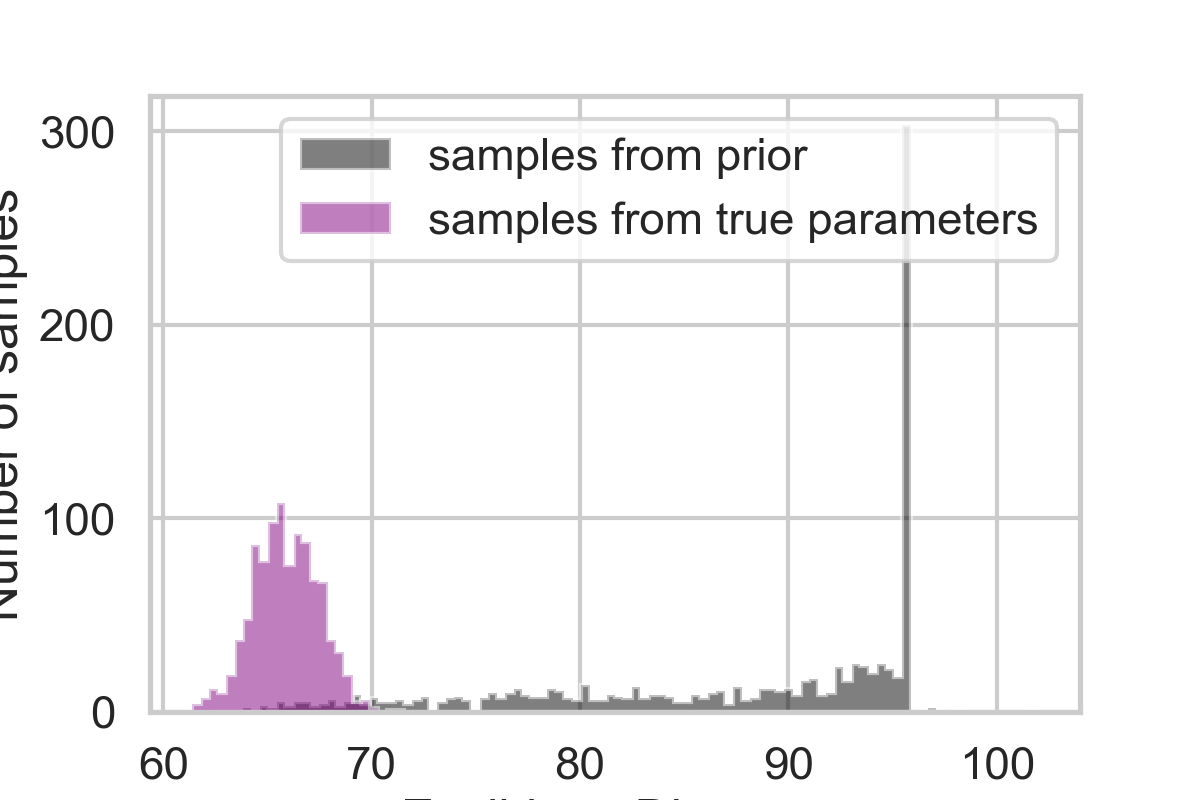

Text(0,0.5,'Number of samples')

In [818]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(e_dist_prior, bins=100, histtype="stepfilled", color="black", alpha=0.5, 
        label="samples from prior", range=xrange);
ax.hist(e_dist_true, bins=100, histtype="stepfilled", color="purple", alpha=0.5, 
        label="samples from true parameters", range=xrange);

ax.legend()
ax.set_xlabel("Euclidean Distance")
ax.set_ylabel("Number of samples")

Huh, cool. So that means the Euclidean distance seems to work not too badly for this. Let's run some simulations where we *only* accept samples with a Euclidean distance < 70, i.e. simple rejection sampling:

In [820]:
len(e_dist_prior[e_dist_prior <= 70])

64

This means that about 6% of simulations are accepted. That's kind of an awful rate, but let's see how we do:

In [821]:
e_dist_all = []
e_dist_accept = []

pars_all = []
pars_accept = []

nsims = 500

while len(e_dist_accept) < nsims:
    p = from_prior()
    prior_pars_all[i] = p
    
    sim_bins, sim_spec = simulate_pileup_spec(p, energ_lo, energ_hi, arf, rmf, exposure=1e4)
    e_dist = euclidean_distance(lpost_pileup.spec.counts, sim_spec)
    
    e_dist_all.append(e_dist)
    pars_all.append(p)
    
    if e_dist <= 70:
        e_dist_accept.append(e_dist)
        pars_accept.append(p)
        print(len(e_dist_accept))
    else:
        continue




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


/Users/danielahuppenkothen/work/sw/miniconda3/envs/sherpa2/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


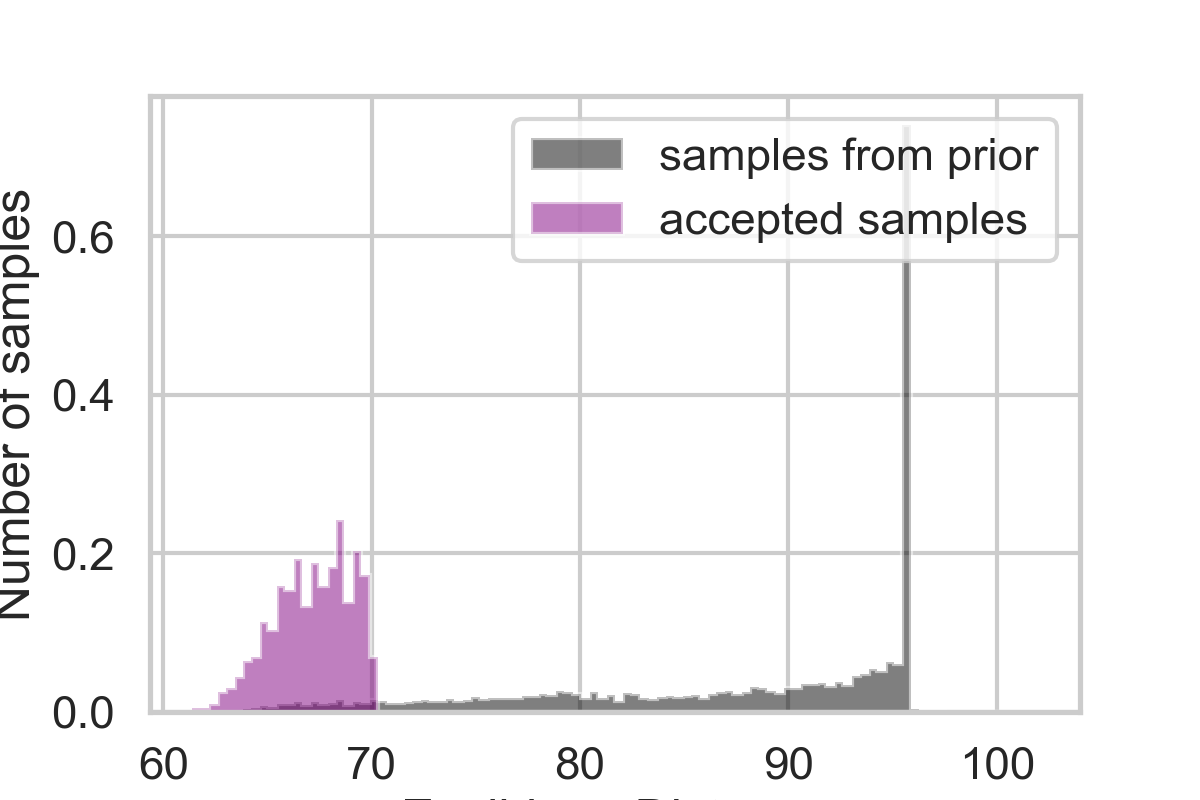

/Users/danielahuppenkothen/work/sw/miniconda3/envs/sherpa2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/danielahuppenkothen/work/sw/miniconda3/envs/sherpa2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Number of samples')

In [823]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(e_dist_all, bins=100, histtype="stepfilled", color="black", alpha=0.5, 
        label="samples from prior", range=xrange, normed=True);
ax.hist(e_dist_accept, bins=100, histtype="stepfilled", color="purple", alpha=0.5, 
        label="accepted samples", range=xrange, normed=True);

ax.legend()
ax.set_xlabel("Euclidean Distance")
ax.set_ylabel("Number of samples")

Let's see what the distribution of parameters looks like for the accepted samples:

/Users/danielahuppenkothen/work/sw/miniconda3/envs/sherpa2/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


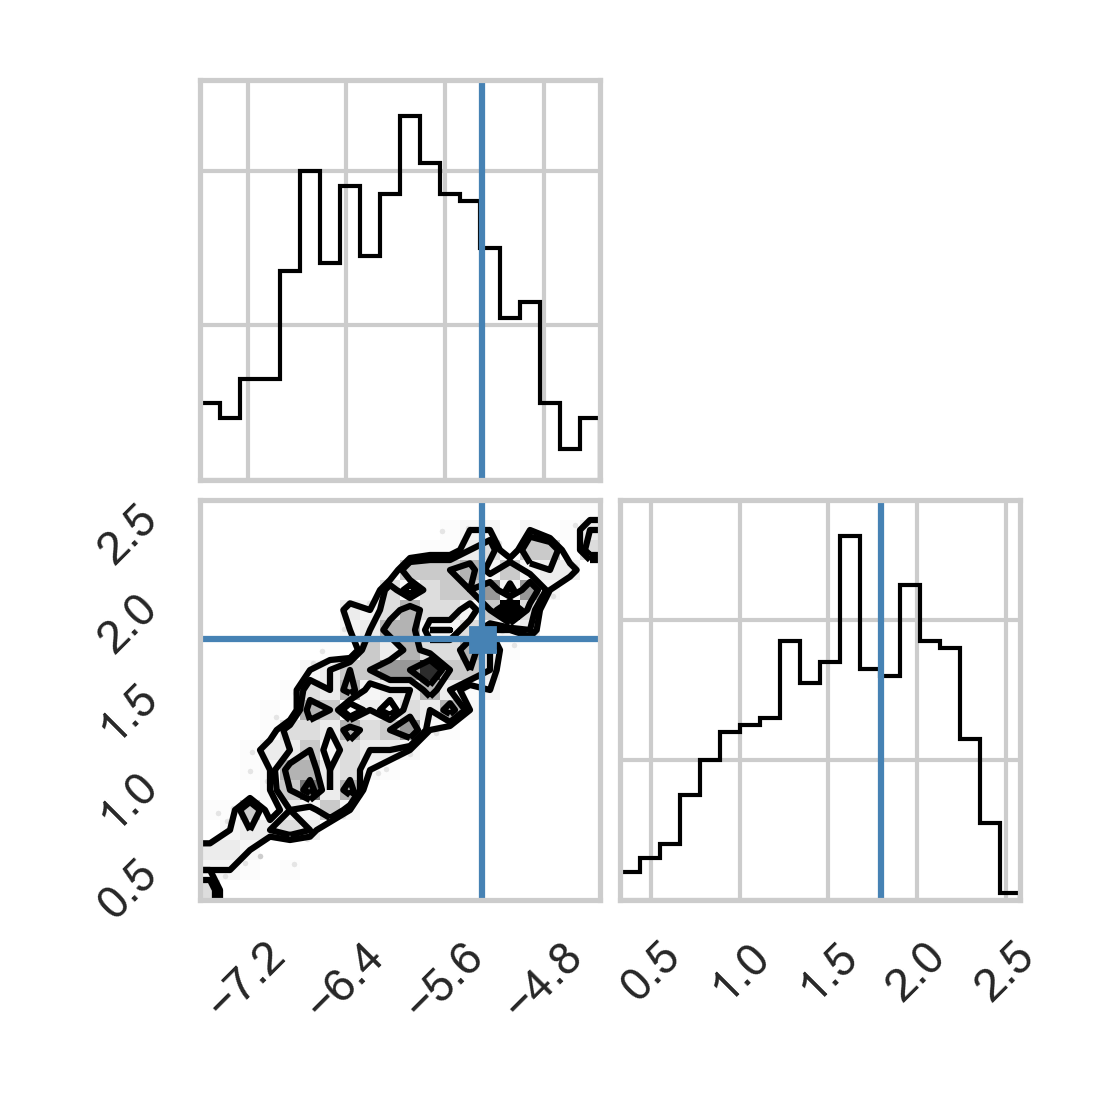

<IPython.core.display.Javascript object>


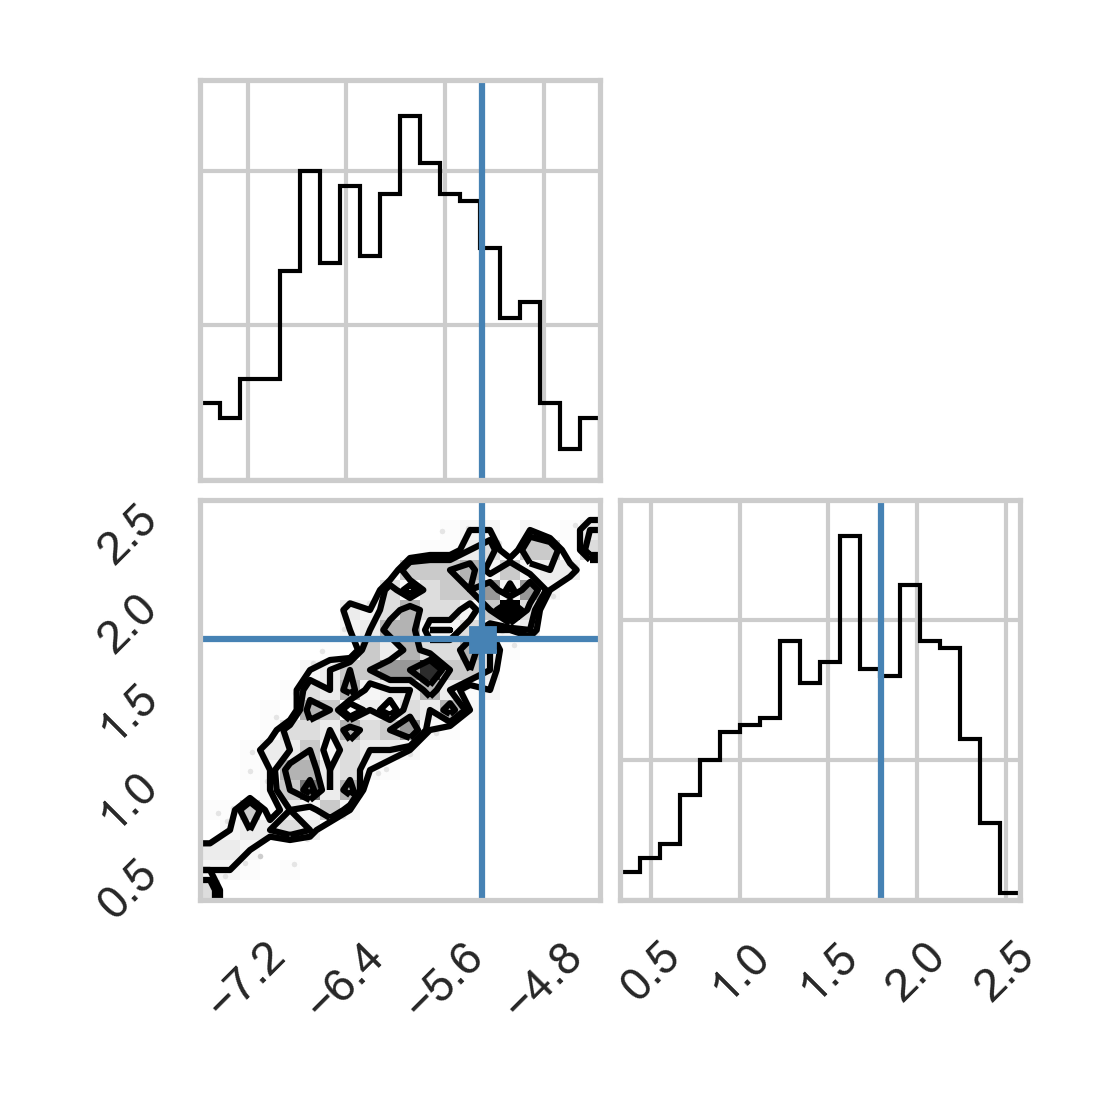

In [825]:
corner.corner(pars_accept, truths=true_pars_lpost)

Hooray! That looks like it's going in the right direction! The distribution is very broad, but I think with better metrics, we might be able to figure that out!

All I wanted to show with this notebook that we can include XSPEC models and X-ray responses in our procedure using sherpa, and that seems to work!